# MIMIC IV Patient Data


## BERT

### 0. Install + Imports

In [ ]:
%%capture
!pip install datasets pyarrow transformers bitsandbytes accelerate pandas torch

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import warnings
from scipy.stats import linregress, ttest_ind, levene
from tqdm import tqdm
import numpy as np

warnings.filterwarnings('ignore')

### 1. Load in preprocessed dataset


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mimic_iv_lab_test_individual.csv')

In [ ]:
df.head()

,input,target,label
0,Tested for Hematocrit in Blood\nDay 1: 41.4 \n...,Tested for Hematocrit in Blood\nTrend is incre...,True
1,Tested for Hematocrit in Blood\nDay 1: 35.3 \n...,Tested for Hematocrit in Blood\nTrend is decre...,True
2,Tested for Hematocrit in Blood\nDay 1: 45.2 \n...,Tested for Hematocrit in Blood\nTrend is decre...,True
3,Tested for Hematocrit in Blood\nDay 1: 32.7 \n...,Tested for Hematocrit in Blood\nTrend is incre...,True
4,Tested for Hematocrit in Blood\nDay 1: 35.6 \n...,Tested for Hematocrit in Blood\nTrend is incre...,True


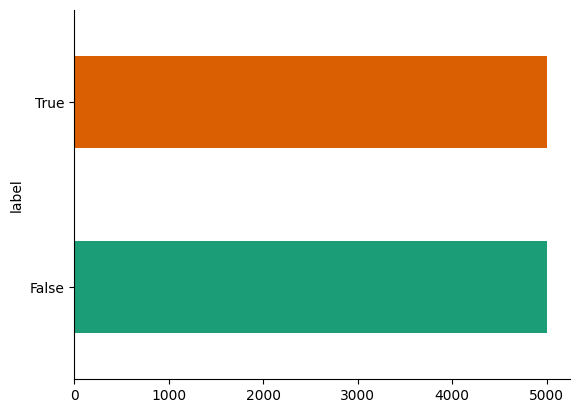

In [ ]:
# Distribution between anomaly and non anomaly, this is already preprocessed data so I have already balanced them
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### 2. Load in necessary packages and prepare for training

In [ ]:
# Importing necessary libraries for inference
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, log_loss
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

In [ ]:
# Shuffle the data
df = df.sample(frac=0.1).reset_index(drop=True)

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)


### 3. Load in BERT model

In [ ]:
# Initialize tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
base_model = DistilBertModel.from_pretrained(model_name)

# Set up GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### 4. Soft Prompts!!!

In [ ]:
class SoftPrompt(nn.Module):
    def __init__(self, num_virtual_tokens, embedding_size):
        super().__init__()
        self.soft_prompt = nn.Parameter(torch.randn(1, num_virtual_tokens, embedding_size))

    def forward(self, batch_size):
        # Expand the soft prompt tensor to the batch size
        return self.soft_prompt.expand(batch_size, -1, -1)

In [ ]:
# Model with soft prompts
class SoftPromptModel(nn.Module):
    def __init__(self, base_model, num_virtual_tokens, num_labels):
        super().__init__()
        self.base_model = base_model
        self.soft_prompt = SoftPrompt(num_virtual_tokens, base_model.config.hidden_size)
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get the batch size from the input_ids tensor
        batch_size = input_ids.shape[0]
        embeddings = self.base_model.embeddings.word_embeddings(input_ids)
        # Pass the batch size to the soft_prompt forward method
        soft_prompt_embeddings = self.soft_prompt(batch_size)

        # Concatenate soft prompt embeddings with input embeddings
        inputs_embeds = torch.cat([soft_prompt_embeddings, embeddings], dim=1)


        # Adjust attention mask for soft prompt
        soft_prompt_attention_mask = torch.ones((attention_mask.shape[0], self.soft_prompt.soft_prompt.shape[1]),
                                                dtype=torch.long, device=attention_mask.device)
        extended_attention_mask = torch.cat([soft_prompt_attention_mask, attention_mask], dim=1)

        outputs = self.base_model(inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask)
        sequence_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token output
        logits = self.classifier(sequence_output)
        return logits

### 5. Preparation for training

In [ ]:
# Initialize model
num_virtual_tokens = 20
model = SoftPromptModel(base_model, num_virtual_tokens, num_labels=2).to(device)

# Define dataset class
class MIMICDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['input']
        label = 1 if row['label'] else 0

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set up datasets and dataloaders
max_length = 512 - num_virtual_tokens  # Adjust for soft prompt
batch_size = 32

train_dataset = MIMICDataset(train_df, tokenizer, max_length)
val_dataset = MIMICDataset(val_df, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 10
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=total_steps)

# Training loop
num_epochs = 10
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

### 6. Training

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.shape[0]

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = correct_predictions.double() / total_predictions

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Average validation loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/LLM_for_TS/mimic_iv_model_epoch_{epoch+1}.pt')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy.item())


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.66it/s]


Epoch 1/10
Average training loss: 0.3728
Average validation loss: 0.2856
Validation Accuracy: 0.8800


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


Epoch 2/10
Average training loss: 0.0648
Average validation loss: 0.3868
Validation Accuracy: 0.8800


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


Epoch 3/10
Average training loss: 0.0268
Average validation loss: 0.4528
Validation Accuracy: 0.8500


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.20it/s]


Epoch 4/10
Average training loss: 0.0211
Average validation loss: 0.5000
Validation Accuracy: 0.8700


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.07it/s]


Epoch 5/10
Average training loss: 0.0232
Average validation loss: 0.5411
Validation Accuracy: 0.8600


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.68it/s]


Epoch 6/10
Average training loss: 0.0203
Average validation loss: 0.5761
Validation Accuracy: 0.8700


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.09it/s]


Epoch 7/10
Average training loss: 0.0138
Average validation loss: 0.6603
Validation Accuracy: 0.8700


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Epoch 8/10
Average training loss: 0.0204
Average validation loss: 0.6870
Validation Accuracy: 0.8700


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.16it/s]


Epoch 9/10
Average training loss: 0.0300
Average validation loss: 0.6446
Validation Accuracy: 0.8600


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.22it/s]


Epoch 10/10
Average training loss: 0.0384
Average validation loss: 0.6304
Validation Accuracy: 0.8600


## Gemma 2b

### 0. Install + Imports

In [ ]:
%%capture
!pip install -U transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

### 1. Load in preprocessed dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mimic_iv_lab_test_individual.csv')
# Expecting columns: 'input' (str) and 'label' (bool or 0/1). If your labels are strings, map them below.
if df['label'].dtype == 'bool':
    df['label'] = df['label'].astype(int)
elif df['label'].dtype == 'O':
    # Example mapping if your text contains sentences like "No abnormality" for negative class.
    df['label'] = df['label'].str.contains('No abnormality', case=False, na=False).map({True:0, False:1}).astype(int)

print(df.head())
train_df, val_df = train_test_split(df.sample(frac=1.0, random_state=42), test_size=0.1, random_state=42)

                                               input  \
0  Tested for Hematocrit in Blood\nDay 1: 41.4 \n...   
1  Tested for Hematocrit in Blood\nDay 1: 35.3 \n...   
2  Tested for Hematocrit in Blood\nDay 1: 45.2 \n...   
3  Tested for Hematocrit in Blood\nDay 1: 32.7 \n...   
4  Tested for Hematocrit in Blood\nDay 1: 35.6 \n...   

                                              target  label  
0  Tested for Hematocrit in Blood\nTrend is incre...      1  
1  Tested for Hematocrit in Blood\nTrend is decre...      1  
2  Tested for Hematocrit in Blood\nTrend is decre...      1  
3  Tested for Hematocrit in Blood\nTrend is incre...      1  
4  Tested for Hematocrit in Blood\nTrend is incre...      1  


### 2. Load in Gemma Model

In [ ]:
from transformers import BitsAndBytesConfig

# Model selection
model_id = "google/gemma-2b"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
)

try:
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    # Ensure pad token exists
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto" if torch.cuda.is_available() else None,
        quantization_config=bnb_config if torch.cuda.is_available() else None,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    )
except Exception as e:
    print("4-bit load failed or not supported; retrying in full precision. Error:", e)
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_id)  # CPU/full precision fallback

# Freeze base model
for p in model.parameters():
    p.requires_grad = False

model.eval()
print("Model loaded.")

base_dtype = model.get_input_embeddings().weight.dtype
print("Base dtype:", base_dtype)

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded.
Base dtype: torch.bfloat16


### 3. Soft Prompts!!!

In [ ]:
class SoftPromptForGemma(nn.Module):
    def __init__(self, base_model, hidden_size, num_virtual_tokens=20, num_labels=2, dropout=0.1, pooling='mean'):
        super().__init__()
        self.base_model = base_model
        self.embed = base_model.get_input_embeddings()
        self.hidden_size = hidden_size
        self.num_virtual_tokens = num_virtual_tokens

        # create prompt in same dtype as the base model embeddings
        prompt = torch.randn(1, num_virtual_tokens, hidden_size, dtype=self.embed.weight.dtype) * 0.02
        self.soft_prompt = nn.Parameter(prompt)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)
        # move classifier weights to same dtype as model
        self.classifier.to(self.embed.weight.dtype)

        self.pooling = pooling  # 'mean' | 'first' | 'last'

    def forward(self, input_ids, attention_mask=None, labels=None):
        B, T = input_ids.shape

        token_embeds = self.embed(input_ids)  # [B,T,H] (bf16)
        sp = self.soft_prompt.expand(B, -1, -1)  # [B,P,H] (bf16)
        inputs_embeds = torch.cat([sp, token_embeds], dim=1)  # (bf16)

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        sp_mask = torch.ones((B, self.num_virtual_tokens), dtype=attention_mask.dtype, device=attention_mask.device)
        attn = torch.cat([sp_mask, attention_mask], dim=1)

        outputs = self.base_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )
        last_hidden = outputs.hidden_states[-1]  # (bf16)

        if self.pooling == 'mean':
            tok_mask = attn[:, self.num_virtual_tokens:].unsqueeze(-1)  # [B,T,1]
            summed = (last_hidden[:, self.num_virtual_tokens:, :] * tok_mask).sum(dim=1)
            counts = tok_mask.sum(dim=1).clamp(min=1)
            pooled = summed / counts
        elif self.pooling == 'first':
            pooled = last_hidden[:, self.num_virtual_tokens, :]
        else:  # 'last'
            lengths = attention_mask.sum(dim=1) - 1
            pooled = last_hidden[torch.arange(B, device=lengths.device), self.num_virtual_tokens + lengths, :]

        # ensure pooled is same dtype as classifier
        pooled = pooled.to(self.classifier.weight.dtype)

        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {'loss': loss, 'logits': logits}

### 4. Preparation for training

In [ ]:
class MIMICDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['input'])
        label = int(row['label'])
        enc = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

max_length = 256
batch_size = 16

train_ds = MIMICDataset(train_df, tokenizer, max_length=max_length)
val_ds = MIMICDataset(val_df, tokenizer, max_length=max_length)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
hidden_size = model.config.hidden_size if hasattr(model.config, 'hidden_size') else model.config.hidden_size
soft_model = SoftPromptForGemma(model, hidden_size, num_virtual_tokens=20, num_labels=2, dropout=0.1, pooling='mean')
soft_model.to(device)

# Only optimize soft prompt + classifier
optim_params = [p for p in soft_model.parameters() if p.requires_grad]
print("Trainable parameter count:", sum(p.numel() for p in optim_params))

optimizer = AdamW(optim_params, lr=2e-4, weight_decay=0.0)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

Trainable parameter count: 45058


### 6. Training

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out['loss']
            logits = out['logits']
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item() * labels.size(0)
    return loss_sum / max(total,1), correct / max(total,1)

global_step = 0
for epoch in range(1, num_epochs+1):
    soft_model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    running = 0.0
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = soft_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out['loss']
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(soft_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        running += loss.item()
        global_step += 1
        if global_step % 10 == 0:
            pbar.set_postfix(loss=f"{running/10:.4f}")
            running = 0.0

    val_loss, val_acc = evaluate(soft_model, val_loader)
    print(f"Validation: loss={val_loss:.4f} acc={val_acc:.4f}")

Epoch 1/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.5174]


Validation: loss=0.5542 acc=0.7290


Epoch 2/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.5270]


Validation: loss=0.5252 acc=0.7450


Epoch 3/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.4793]


Validation: loss=0.5156 acc=0.7500


Epoch 4/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.5705]


Validation: loss=0.5176 acc=0.7300


Epoch 5/10: 100%|██████████| 563/563 [02:58<00:00,  3.15it/s, loss=0.4568]


Validation: loss=0.4884 acc=0.7630


Epoch 6/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.4754]


Validation: loss=0.4801 acc=0.7710


Epoch 7/10: 100%|██████████| 563/563 [02:59<00:00,  3.15it/s, loss=0.4703]


Validation: loss=0.4815 acc=0.7690


Epoch 8/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.4867]


Validation: loss=0.4783 acc=0.7800


Epoch 9/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.3914]


Validation: loss=0.4787 acc=0.7760


Epoch 10/10: 100%|██████████| 563/563 [02:59<00:00,  3.14it/s, loss=0.4328]


Validation: loss=0.4788 acc=0.7760


## Llama 3.2 1b


### 0. Install + Imports

In [ ]:
%%capture
!pip install -U transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn

In [ ]:
import os, math, random, warnings
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
warnings.filterwarnings('ignore')


### 1. Load in preprocessed dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mimic_iv_lab_test_individual.csv')
# Expecting columns: 'input' (str) and 'label' (bool or 0/1). If your labels are strings, map them below.
if df['label'].dtype == 'bool':
    df['label'] = df['label'].astype(int)
elif df['label'].dtype == 'O':
    # Example mapping if your text contains sentences like "No abnormality" for negative class.
    df['label'] = df['label'].str.contains('No abnormality', case=False, na=False).map({True:0, False:1}).astype(int)

print(df.head())
train_df, val_df = train_test_split(df.sample(frac=1.0, random_state=42), test_size=0.1, random_state=42)

                                               input  \
0  Tested for Hematocrit in Blood\nDay 1: 41.4 \n...   
1  Tested for Hematocrit in Blood\nDay 1: 35.3 \n...   
2  Tested for Hematocrit in Blood\nDay 1: 45.2 \n...   
3  Tested for Hematocrit in Blood\nDay 1: 32.7 \n...   
4  Tested for Hematocrit in Blood\nDay 1: 35.6 \n...   

                                              target  label  
0  Tested for Hematocrit in Blood\nTrend is incre...      1  
1  Tested for Hematocrit in Blood\nTrend is decre...      1  
2  Tested for Hematocrit in Blood\nTrend is decre...      1  
3  Tested for Hematocrit in Blood\nTrend is incre...      1  
4  Tested for Hematocrit in Blood\nTrend is incre...      1  


### 2. Load in Llama model

In [ ]:
from transformers import BitsAndBytesConfig

# Model selection
model_id = "meta-llama/Llama-3.2-1B"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
)

try:
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    # Ensure pad token exists
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(
      model_id,
      device_map="auto" if torch.cuda.is_available() else None,
      torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
      quantization_config=bnb_config if torch.cuda.is_available() else None,
  )
except Exception as e:
    print("4-bit load failed or not supported; retrying in full precision. Error:", e)
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_id)  # CPU/full precision fallback

# Freeze base model
for p in model.parameters():
    p.requires_grad = False

model.eval()
print("Model loaded.")
base_dtype = model.get_input_embeddings().weight.dtype
print(base_dtype)


Using device: cuda
Model loaded.
torch.bfloat16


### 3. Soft Prompts!!!

In [ ]:
class SoftPromptForLlama(nn.Module):
    def __init__(self, base_model, hidden_size, num_virtual_tokens=20, num_labels=2, dropout=0.1, pooling='mean'):
        super().__init__()
        self.base_model = base_model
        self.embed = base_model.get_input_embeddings()
        self.hidden_size = hidden_size
        self.num_virtual_tokens = num_virtual_tokens
        self.pooling = pooling

        # params in same dtype as embeddings (bf16 for 4-bit Llama)
        prompt = torch.randn(1, num_virtual_tokens, hidden_size, dtype=self.embed.weight.dtype) * 0.02
        self.soft_prompt = nn.Parameter(prompt)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.classifier.to(self.embed.weight.dtype)  # <- crucial

    def forward(self, input_ids, attention_mask=None, labels=None):
        B, T = input_ids.shape

        token_embeds = self.embed(input_ids)           # [B,T,H] (bf16)
        sp = self.soft_prompt.expand(B, -1, -1)        # [B,P,H] (bf16)
        inputs_embeds = torch.cat([sp, token_embeds], dim=1)

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        sp_mask = torch.ones((B, self.num_virtual_tokens), dtype=attention_mask.dtype, device=attention_mask.device)
        attn = torch.cat([sp_mask, attention_mask], dim=1)

        outputs = self.base_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )
        last_hidden = outputs.hidden_states[-1]        # (bf16)

        if self.pooling == 'mean':
            tok_mask = attn[:, self.num_virtual_tokens:].unsqueeze(-1)
            summed = (last_hidden[:, self.num_virtual_tokens:, :] * tok_mask).sum(dim=1)
            counts = tok_mask.sum(dim=1).clamp(min=1)
            pooled = summed / counts
        elif self.pooling == 'first':
            pooled = last_hidden[:, self.num_virtual_tokens, :]
        else:  # 'last'
            lengths = attention_mask.sum(dim=1) - 1
            pooled = last_hidden[torch.arange(B, device=lengths.device),
                                 self.num_virtual_tokens + lengths, :]

        # ensure classifier input matches classifier weights dtype
        pooled = pooled.to(self.classifier.weight.dtype)

        logits = self.classifier(self.dropout(pooled))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {'loss': loss, 'logits': logits}

### Preparation for training

In [ ]:
class MIMICDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['input'])
        label = int(row['label'])
        enc = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

max_length = 256
batch_size = 16

train_ds = MIMICDataset(train_df, tokenizer, max_length=max_length)
val_ds = MIMICDataset(val_df, tokenizer, max_length=max_length)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
hidden_size = model.config.hidden_size if hasattr(model.config, 'hidden_size') else model.config.hidden_size
soft_model = SoftPromptForLlama(model, hidden_size, num_virtual_tokens=20, num_labels=2, dropout=0.1, pooling='mean')
soft_model.to(device)

# Only optimize soft prompt + classifier
optim_params = [p for p in soft_model.parameters() if p.requires_grad]
print("Trainable parameter count:", sum(p.numel() for p in optim_params))

optimizer = AdamW(optim_params, lr=2e-4, weight_decay=0.0)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

Trainable parameter count: 45058


### 6. Training


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
import numpy as np
import torch
import math

def evaluate(model, loader, device=device):
    model.eval()
    ys, y_preds, y_probs = [], [], []
    loss_sum, total = 0.0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = out['loss'], out['logits']

            # ensure float32 for downstream numpy metrics (avoid bfloat16 issues)
            logits = logits.float()

            # Track loss/size
            bs = labels.size(0)
            loss_sum += loss.item() * bs
            total += bs

            # Predictions / probabilities
            if logits.dim() == 1:
                probs_pos = torch.sigmoid(logits).unsqueeze(1)                # (B,1) float32
                preds = (probs_pos[:, 0] >= 0.5).long()
                probs = torch.stack([1 - probs_pos[:, 0], probs_pos[:, 0]], dim=1)  # (B,2)
            else:
                C = logits.size(-1)
                if C == 1:
                    p1 = torch.sigmoid(logits.squeeze(-1))                    # (B,)
                    preds = (p1 >= 0.5).long()
                    probs = torch.stack([1 - p1, p1], dim=1)                  # (B,2)
                else:
                    probs = torch.softmax(logits, dim=-1)                     # (B,C)
                    preds = probs.argmax(dim=-1)

            ys.append(labels.detach().cpu())
            y_preds.append(preds.detach().cpu())
            y_probs.append(probs.detach().cpu().float())  # <-- force float32 on CPU

    # Stack on CPU (now float32-safe)
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(y_preds).numpy()
    y_prob = torch.cat(y_probs).numpy()   # shape (N, C), float32

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)

    num_classes = y_prob.shape[1]
    if num_classes == 2:
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )
        try:
            auroc = roc_auc_score(y_true, y_prob[:, 1])
        except ValueError:
            auroc = float('nan')
        try:
            aupr = average_precision_score(y_true, y_prob[:, 1])
        except ValueError:
            aupr = float('nan')
    else:
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )
        try:
            auroc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        except ValueError:
            auroc = float('nan')
        try:
            Y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
            aupr = average_precision_score(Y_true_bin, y_prob, average='macro')
        except ValueError:
            aupr = float('nan')

    avg_loss = loss_sum / max(total, 1)
    return {
        "loss": avg_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auroc": auroc,
        "aupr": aupr,
    }


# ---- training loop (prints full metric set each epoch) ----
global_step = 0
for epoch in range(1, num_epochs+1):
    soft_model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    running = 0.0
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        out = soft_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out['loss']
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(soft_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running += loss.item()
        global_step += 1
        if global_step % 10 == 0:
            pbar.set_postfix(loss=f"{running/10:.4f}")
            running = 0.0

    val_metrics = evaluate(soft_model, val_loader, device=device)
    print(
        "Validation: "
        f"loss={val_metrics['loss']:.4f} "
        f"acc={val_metrics['accuracy']:.4f} "
        f"prec={val_metrics['precision']:.4f} "
        f"rec={val_metrics['recall']:.4f} "
        f"f1={val_metrics['f1']:.4f} "
        f"auroc={val_metrics['auroc'] if not math.isnan(val_metrics['auroc']) else 'nan'} "
        f"aupr={val_metrics['aupr'] if not math.isnan(val_metrics['aupr']) else 'nan'}"
    )


Epoch 1/10: 100%|██████████| 563/563 [01:47<00:00,  5.24it/s, loss=0.3974]


Validation: loss=0.4536 acc=0.7930 prec=0.7747 rec=0.8343 f1=0.8034 auroc=0.8860856727918671 aupr=0.8976681846321928


Epoch 2/10: 100%|██████████| 563/563 [01:46<00:00,  5.27it/s, loss=0.3906]


Validation: loss=0.4187 acc=0.7990 prec=0.9158 rec=0.6647 f1=0.7703 auroc=0.9172257762521454 aupr=0.9252736229185509


Epoch 3/10: 100%|██████████| 563/563 [01:46<00:00,  5.27it/s, loss=0.3388]


Validation: loss=0.3500 acc=0.8470 prec=0.8672 rec=0.8245 f1=0.8453 auroc=0.9252213433833031 aupr=0.9331565187506405


Epoch 4/10: 100%|██████████| 563/563 [01:46<00:00,  5.26it/s, loss=0.3308]


Validation: loss=0.3505 acc=0.8490 prec=0.9140 rec=0.7751 f1=0.8388 auroc=0.9311385031466168 aupr=0.9390552446168349


Epoch 5/10: 100%|██████████| 563/563 [01:47<00:00,  5.24it/s, loss=0.3154]


Validation: loss=0.3289 acc=0.8530 prec=0.8689 rec=0.8363 f1=0.8523 auroc=0.9338510348028213 aupr=0.9413002896166296


Epoch 6/10: 100%|██████████| 563/563 [01:47<00:00,  5.26it/s, loss=0.3026]


Validation: loss=0.3248 acc=0.8610 prec=0.8882 rec=0.8304 f1=0.8583 auroc=0.9353893363099167 aupr=0.9430712872906237


Epoch 7/10: 100%|██████████| 563/563 [01:47<00:00,  5.26it/s, loss=0.2643]


Validation: loss=0.3243 acc=0.8620 prec=0.8884 rec=0.8323 f1=0.8595 auroc=0.9354533488563759 aupr=0.9433011566522789


Epoch 8/10: 100%|██████████| 563/563 [01:47<00:00,  5.26it/s, loss=0.2853]


Validation: loss=0.3242 acc=0.8610 prec=0.8882 rec=0.8304 f1=0.8583 auroc=0.9355213621869887 aupr=0.9433237134696479


Epoch 9/10: 100%|██████████| 563/563 [01:47<00:00,  5.25it/s, loss=0.2954]


Validation: loss=0.3230 acc=0.8580 prec=0.8842 rec=0.8284 f1=0.8554 auroc=0.9362154982376545 aupr=0.9437427221242214


Epoch 10/10: 100%|██████████| 563/563 [01:47<00:00,  5.26it/s, loss=0.2283]


Validation: loss=0.3241 acc=0.8580 prec=0.8747 rec=0.8402 f1=0.8571 auroc=0.935567371204756 aupr=0.9431483002982642


# NASA

## BERT

### 0. Install + Imports

In [ ]:
%%capture
!pip install -U transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn tslearn

In [ ]:
import os
import numpy as np
import pandas as pd

### 1. Loading in dataset and preprocessing

In [ ]:
import ast

def load_npy_files_to_dataframes(folder_path):
    datasets = {}

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)

            # Load the .npy file
            data = np.load(file_path, allow_pickle=True)

            # Convert to pandas DataFrame
            if data.ndim == 1:
                df = pd.DataFrame(data, columns=['value'])
            elif data.ndim == 2:
                df = pd.DataFrame(data)
            else:
                print(f"Skipping {filename}: Unsupported number of dimensions")
                continue

            # Store the DataFrame using the filename (without .npy extension) as the key
            key = os.path.splitext(filename)[0]
            datasets[key] = df

    return datasets

folder = '/content/drive/MyDrive/data/test'
datasets = load_npy_files_to_dataframes(folder)

datasets_to_include = ['P-1',
                       'E-1',
                       'E-10',
                       'E-11',
                       'E-12',
                       'E-13',
                       'P-4',
                       'T-1',
                       'T-3',
                       'G-7',
                       'F-7',
                       'C-1',
                       'C-2',
                       'T-13',
                       'D-14',
                       'T-9',
                       'T-8',
                       'P-11']

for key in list(datasets.keys()):
    if key not in datasets_to_include:
        del datasets[key]

labels = pd.read_csv('/content/drive/MyDrive/data/labeled_anomalies.csv', index_col = None )
for row in labels.iterrows():
    if row[1]['chan_id'] not in datasets:
        continue
    cur_df = datasets[row[1]['chan_id']]
    # print(type(row[1]['class']))
    anomaly_types = row[1]['class'].strip('[]').split(', ')
    anomalies = ast.literal_eval(row[1]['anomaly_sequences'])

    # print(cur_df[0])
    # print(anomalies)
    for anomaly in zip(anomaly_types, anomalies):
        if anomaly[0] == 'contextual':
    # training_datasets[row[1]['chan_id']] =
            cur_df['anomaly'] = 0
            if anomaly[1][1] >= len(cur_df):
                break
            cur_df.loc[anomaly[1][0]:anomaly[1][1], 'anomaly'] = 1
        else:
            cur_df['anomaly'] = 0
            if anomaly[1][1] >= len(cur_df):
                break
            cur_df.loc[anomaly[1][0]:anomaly[1][1], 'anomaly'] = 1
        # print(cur_df.iloc[anomaly[1][0]:anomaly[1][1]])
    datasets[row[1]['chan_id']] = cur_df


In [ ]:
def split_sequences(data, sequence_length=100, stride=10):
    """
    Split the data into sequences of specified length.

    :param data: pandas DataFrame with 'values' and 'anomaly' columns
    :param sequence_length: length of each sequence
    :param stride: number of steps to move forward for each new sequence
    :return: list of sequences, where each sequence is a dict with 'values' and 'anomaly' keys
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, stride):
        sequence = {
            'values': data[0].iloc[i:i+sequence_length].tolist(),
            'anomaly': data['anomaly'].iloc[i:i+sequence_length].tolist()
        }
        sequences.append(sequence)
    return sequences

def create_labeled_sequences(sequences):
    """
    Label each sequence based on whether it contains an anomaly.

    :param sequences: list of sequences
    :return: list of labeled sequences, where each is a dict with 'values', 'anomaly', and 'contains_anomaly' keys
    """
    labeled_sequences = []
    for seq in sequences:
        labeled_seq = seq.copy()
        labeled_seq['contains_anomaly'] = 1 if sum(seq['anomaly']) > 0 else 0
        labeled_sequences.append(labeled_seq)
    return labeled_sequences

for name, dataset in datasets.items():
    sequences = split_sequences(dataset)
    labeled_sequences = create_labeled_sequences(sequences)
    labeled_sequences = pd.DataFrame(labeled_sequences)
    labeled_sequences.drop(['anomaly'], axis = 1, inplace = True)
    datasets[name] = labeled_sequences

In [ ]:
final_df = pd.DataFrame()
for name, dataset in datasets.items():
    final_df = pd.concat([final_df, dataset])

final_df = datasets['P-1']

In [ ]:
import numpy as np
from collections import Counter
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

def t_smote(X, y, sampling_strategy=1.0, k_neighbors=5, random_state=None):
    np.random.seed(random_state)
    # Separate minority and majority classes
    counter = Counter(y)
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)

    X_minority = X[y == minority_class]
    n_minority = len(X_minority)
    n_majority = counter[majority_class]
    n_samples_generate = int(n_minority * sampling_strategy)

    # If X is 2D, reshape to 3D by adding a new axis
    if X_minority.ndim == 2:
        X_minority = X_minority[:, :, np.newaxis]  # Shape: (n_samples, n_timestamps, 1)

    # Scaling time series
    scaler = TimeSeriesScalerMeanVariance()
    X_minority_scaled = scaler.fit_transform(X_minority)

    # Find k-nearest neighbors for each minority sample
    knn = KNeighborsTimeSeries(n_neighbors=min(k_neighbors, n_minority), metric="dtw")
    knn.fit(X_minority_scaled)
    neighbors = knn.kneighbors(X_minority_scaled, return_distance=False)

    synthetic_samples = []
    for _ in range(n_samples_generate):
        idx = np.random.randint(len(X_minority))
        neighbor_idx = np.random.choice(neighbors[idx][1:]) if len(neighbors[idx]) > 1 else idx
        lam = np.random.rand()
        synthetic_sample = (1 - lam) * X_minority[idx] + lam * X_minority[neighbor_idx]
        synthetic_samples.append(synthetic_sample)

    X_synthetic = np.array(synthetic_samples)

    # If original data was 2D, reshape synthetic samples back to 2D
    if X.ndim == 2:
        X_synthetic = X_synthetic.squeeze(axis=2)  # Remove the singleton dimension
        X_resampled = np.vstack((X, X_synthetic))
    else:
        X_resampled = np.vstack((X, X_synthetic))

    y_synthetic = np.array([minority_class] * len(X_synthetic))
    y_resampled = np.hstack((y, y_synthetic))

    return X_resampled, y_resampled


# Calculate the sampling strategy to balance the classes
def calculate_sampling_strategy(y):
    counter = Counter(y)
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)
    n_majority = counter[majority_class]
    n_minority = counter[minority_class]
    # Number of samples to generate
    n_samples_generate = n_majority - n_minority
    # Sampling strategy is the ratio of samples to generate to the number of minority samples
    sampling_strategy = n_samples_generate / n_minority
    return sampling_strategy

### 2. Load in BERT model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import warnings
from transformers import DistilBertTokenizer, DistilBertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, recall_score, roc_auc_score, average_precision_score, precision_score, accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
import time

def balance_quantize_and_prepare_data(X, y, tokenizer, num_bins=100, max_length=100, test= False):
    X = np.array([np.array(x) for x in X])
    y = np.array(y)

    if test == False:
        # Print class distribution before balancing
        print("Original class distribution:", Counter(y))

        sampling_strategy = calculate_sampling_strategy(y)

        # Apply T-SMOTE with the calculated sampling strategy
        X_tsmote, y_tsmote = t_smote(X, y, sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)

        # Verify the new class distribution
        print("After T-SMOTE class distribution:", Counter(y_tsmote))

        # If oversampling alone achieves a 1:1 ratio, no need to undersample
        # But if you want to ensure exact balance, you can undersample the majority class
        counter = Counter(y_tsmote)
        n_minority = counter[min(counter, key=counter.get)]
        n_majority = counter[max(counter, key=counter.get)]
        if n_majority > n_minority:
            rus = RandomUnderSampler(sampling_strategy={max(counter, key=counter.get): n_minority}, random_state=42)
            X_reshaped = X_tsmote.reshape((X_tsmote.shape[0], -1))
            X_resampled, y_resampled = rus.fit_resample(X_reshaped, y_tsmote)
            # Reshape X_resampled back to original shape
            if X.ndim == 3:
                n_samples, n_timestamps, n_features = X.shape
                X_resampled = X_resampled.reshape(-1, n_timestamps, n_features)
            elif X.ndim == 2:
                n_samples, n_timestamps = X.shape
                X_resampled = X_resampled.reshape(-1, n_timestamps)
            else:
                raise ValueError("Unexpected X dimensions")
            print("Balanced class distribution after undersampling:", Counter(y_resampled))
        else:
            X_resampled = X_tsmote
            y_resampled = y_tsmote
            print("Balanced class distribution:", Counter(y_resampled))
    else:
        X_resampled = X
        y_resampled = y

    # Quantize each feature separately
    X_quantized = []
    for feature in X_resampled.T:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kbd = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
            quantized_feature = kbd.fit_transform(feature.reshape(-1, 1)).flatten()
            X_quantized.append([f"Q{int(val)}" for val in quantized_feature])

    # Transpose X_quantized back to original shape
    X_quantized = list(map(list, zip(*X_quantized)))

    # Join the quantized features into strings
    X_quantized_str = [' '.join(row) for row in X_quantized]

    # Scale the original values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)

    # Combine quantized strings with scaled values
    X_combined = [f"{q_str} {' '.join(map(str, scaled))}" for q_str, scaled in zip(X_quantized_str, X_scaled)]

    # Tokenize the combined data
    encodings = tokenizer(X_combined, truncation=True, padding=True, max_length=max_length)

    # Convert to tensors
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(y_resampled)

    return TensorDataset(input_ids, attention_mask, labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = final_df['values']
y = final_df['contains_anomaly']

# Initialize tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
base_model = DistilBertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Assuming X and y are your features and labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare datasets with balancing, quantization, and scaling
train_dataset = balance_quantize_and_prepare_data(X_train, y_train, tokenizer, test = False)
val_dataset = balance_quantize_and_prepare_data(X_val, y_val, tokenizer, test = True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model
num_virtual_tokens = 20
num_labels = 2

Original class distribution: Counter({np.int64(0): 648, np.int64(1): 24})
After T-SMOTE class distribution: Counter({np.int64(0): 648, np.int64(1): 648})
Balanced class distribution: Counter({np.int64(0): 648, np.int64(1): 648})


### 3. Soft Prompts!!!

In [ ]:
class SoftPrompt(nn.Module):
    def __init__(self, num_virtual_tokens, embedding_size):
        super().__init__()
        self.soft_prompt = nn.Parameter(torch.randn(1, num_virtual_tokens, embedding_size))

    def forward(self, batch_size):
        return self.soft_prompt.expand(batch_size, -1, -1)

class SoftPromptModel(nn.Module):
    def __init__(self, base_model, num_virtual_tokens, num_labels):
        super().__init__()
        self.base_model = base_model
        self.soft_prompt = SoftPrompt(num_virtual_tokens, base_model.config.dim)
        self.classifier = nn.Sequential(
            nn.Linear(base_model.config.dim, num_labels)
        )
        self.num_virtual_tokens = num_virtual_tokens

    def forward(self, input_ids, attention_mask):
        batch_size = input_ids.shape[0]

        # Generate soft prompt embeddings
        soft_prompt_embeds = self.soft_prompt(batch_size)

        # Get input embeddings from the base model
        input_embeds = self.base_model.embeddings.word_embeddings(input_ids)

        # Concatenate soft prompt embeddings with input embeddings
        inputs_embeds = torch.cat([soft_prompt_embeds, input_embeds], dim=1)

        # Adjust attention mask for soft prompt
        soft_prompt_attention_mask = torch.ones((batch_size, self.num_virtual_tokens),
                                                dtype=torch.long, device=attention_mask.device)
        extended_attention_mask = torch.cat([soft_prompt_attention_mask, attention_mask], dim=1)

        outputs = self.base_model(inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask)
        pooled_output = outputs.last_hidden_state[:, self.num_virtual_tokens, :]  # Use first token after soft prompt
        logits = self.classifier(pooled_output)
        return logits

### 4. Training

In [ ]:
model = SoftPromptModel(base_model, num_virtual_tokens, num_labels).to(device)

# Calculate class weights
num_samples = len(y_train)
num_classes = len(np.unique(y_train))
class_weights = [num_samples / (num_classes * np.sum(y_train == c)) for c in range(num_classes)]
class_weights = torch.FloatTensor(class_weights).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training setup
optimizer = AdamW(model.parameters(), lr=1e-4)
num_epochs = 10
total_steps = len(train_loader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

validation_accuracies = []
loss_history = []
AUROC_history = []
AUPR_history = []

In [ ]:
# Training loop
start = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    loss_history.append(avg_loss)

    # Evaluation
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(all_labels, all_predictions)
    validation_accuracies.append(accuracy)
    f1 = f1_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    auroc = roc_auc_score(all_labels, all_probabilities)
    aupr = average_precision_score(all_labels, all_probabilities)

    AUROC_history.append(auroc)
    AUPR_history.append(aupr)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, AUROC: {auroc:.4f}, AUPR: {aupr:.4f}")
    print(f"Time elapsed: {time.time() - start} seconds")


Epoch 1/10, Average Loss: 0.0366
Epoch 1/10, Validation Accuracy: 0.8757
F1 Score: 0.3226, Recall: 0.5000, Precision: 0.2381, AUROC: 0.6638, AUPR: 0.1882
Time elapsed: 3.040874719619751 seconds
Epoch 2/10, Average Loss: 0.0060
Epoch 2/10, Validation Accuracy: 0.7041
F1 Score: 0.1935, Recall: 0.6000, Precision: 0.1154, AUROC: 0.7126, AUPR: 0.1858
Time elapsed: 6.028313159942627 seconds
Epoch 3/10, Average Loss: 0.0515
Epoch 3/10, Validation Accuracy: 0.7811
F1 Score: 0.2449, Recall: 0.6000, Precision: 0.1538, AUROC: 0.7135, AUPR: 0.2531
Time elapsed: 9.01585841178894 seconds
Epoch 4/10, Average Loss: 0.0122
Epoch 4/10, Validation Accuracy: 0.8225
F1 Score: 0.2500, Recall: 0.5000, Precision: 0.1667, AUROC: 0.7000, AUPR: 0.1785
Time elapsed: 12.023236274719238 seconds
Epoch 5/10, Average Loss: 0.0043
Epoch 5/10, Validation Accuracy: 0.8166
F1 Score: 0.2439, Recall: 0.5000, Precision: 0.1613, AUROC: 0.7047, AUPR: 0.3574
Time elapsed: 15.030487775802612 seconds
Epoch 6/10, Average Loss: 0.0

## Gemma 2b + Llama 3.2 1B


### 0. Install + Imports

In [1]:
%%capture
!pip install transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn matplotlib numpy tslearn

In [2]:
import os, random, time, warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from transformers.optimization import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import (f1_score, recall_score, precision_score, accuracy_score,
                             roc_auc_score, average_precision_score, confusion_matrix)

from imblearn.under_sampling import RandomUnderSampler

from tslearn.neighbors import KNeighborsTimeSeries

import matplotlib.pyplot as plt

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
supports_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
GLOBAL_DTYPE = torch.bfloat16 if supports_bf16 else (torch.float16 if torch.cuda.is_available() else torch.float32)
print("Device:", device, "| GLOBAL_DTYPE:", GLOBAL_DTYPE)

Device: cuda | GLOBAL_DTYPE: torch.bfloat16


### 1. Loading in dataset and preprocessing

In [4]:
import ast

def load_npy_files_to_dataframes(folder_path):
    datasets = {}

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)

            # Load the .npy file
            data = np.load(file_path, allow_pickle=True)

            # Convert to pandas DataFrame
            if data.ndim == 1:
                df = pd.DataFrame(data, columns=['value'])
            elif data.ndim == 2:
                df = pd.DataFrame(data)
            else:
                print(f"Skipping {filename}: Unsupported number of dimensions")
                continue

            # Store the DataFrame using the filename (without .npy extension) as the key
            key = os.path.splitext(filename)[0]
            datasets[key] = df

    return datasets

folder = '/content/drive/MyDrive/data/test'
datasets = load_npy_files_to_dataframes(folder)

datasets_to_include = ['P-1',
                       'E-1',
                       'E-10',
                       'E-11',
                       'E-12',
                       'E-13',
                       'P-4',
                       'T-1',
                       'T-3',
                       'G-7',
                       'F-7',
                       'C-1',
                       'C-2',
                       'T-13',
                       'D-14',
                       'T-9',
                       'T-8',
                       'P-11']

for key in list(datasets.keys()):
    if key not in datasets_to_include:
        del datasets[key]

labels = pd.read_csv('/content/drive/MyDrive/data/labeled_anomalies.csv', index_col = None )
for row in labels.iterrows():
    if row[1]['chan_id'] not in datasets:
        continue
    cur_df = datasets[row[1]['chan_id']]
    # print(type(row[1]['class']))
    anomaly_types = row[1]['class'].strip('[]').split(', ')
    anomalies = ast.literal_eval(row[1]['anomaly_sequences'])

    # print(cur_df[0])
    # print(anomalies)
    for anomaly in zip(anomaly_types, anomalies):
        if anomaly[0] == 'contextual':
    # training_datasets[row[1]['chan_id']] =
            cur_df['anomaly'] = 0
            if anomaly[1][1] >= len(cur_df):
                break
            cur_df.loc[anomaly[1][0]:anomaly[1][1], 'anomaly'] = 1
        else:
            cur_df['anomaly'] = 0
            if anomaly[1][1] >= len(cur_df):
                break
            cur_df.loc[anomaly[1][0]:anomaly[1][1], 'anomaly'] = 1
        # print(cur_df.iloc[anomaly[1][0]:anomaly[1][1]])
    datasets[row[1]['chan_id']] = cur_df


In [5]:
def split_sequences(data, sequence_length=100, stride=10):
    """
    Split the data into sequences of specified length.

    :param data: pandas DataFrame with 'values' and 'anomaly' columns
    :param sequence_length: length of each sequence
    :param stride: number of steps to move forward for each new sequence
    :return: list of sequences, where each sequence is a dict with 'values' and 'anomaly' keys
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, stride):
        sequence = {
            'values': data[0].iloc[i:i+sequence_length].tolist(),
            'anomaly': data['anomaly'].iloc[i:i+sequence_length].tolist()
        }
        sequences.append(sequence)
    return sequences

def create_labeled_sequences(sequences):
    """
    Label each sequence based on whether it contains an anomaly.

    :param sequences: list of sequences
    :return: list of labeled sequences, where each is a dict with 'values', 'anomaly', and 'contains_anomaly' keys
    """
    labeled_sequences = []
    for seq in sequences:
        labeled_seq = seq.copy()
        labeled_seq['contains_anomaly'] = 1 if sum(seq['anomaly']) > 0 else 0
        labeled_sequences.append(labeled_seq)
    return labeled_sequences

for name, dataset in datasets.items():
    sequences = split_sequences(dataset)
    labeled_sequences = create_labeled_sequences(sequences)
    labeled_sequences = pd.DataFrame(labeled_sequences)
    labeled_sequences.drop(['anomaly'], axis = 1, inplace = True)
    datasets[name] = labeled_sequences

In [6]:
final_df = pd.DataFrame()
for name, dataset in datasets.items():
    final_df = pd.concat([final_df, dataset])

final_df = datasets['P-1']

### 2. T-SMOTE to address class imbalanceness

In [7]:
import numpy as np
from collections import Counter
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

def t_smote(X, y, sampling_strategy=1.0, k_neighbors=5, random_state=None):
    np.random.seed(random_state)
    # Separate minority and majority classes
    counter = Counter(y)
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)

    X_minority = X[y == minority_class]
    n_minority = len(X_minority)
    n_majority = counter[majority_class]
    n_samples_generate = int(n_minority * sampling_strategy)

    # If X is 2D, reshape to 3D by adding a new axis
    if X_minority.ndim == 2:
        X_minority = X_minority[:, :, np.newaxis]  # Shape: (n_samples, n_timestamps, 1)

    # Scaling time series
    scaler = TimeSeriesScalerMeanVariance()
    X_minority_scaled = scaler.fit_transform(X_minority)

    # Find k-nearest neighbors for each minority sample
    knn = KNeighborsTimeSeries(n_neighbors=min(k_neighbors, n_minority), metric="dtw")
    knn.fit(X_minority_scaled)
    neighbors = knn.kneighbors(X_minority_scaled, return_distance=False)

    synthetic_samples = []
    for _ in range(n_samples_generate):
        idx = np.random.randint(len(X_minority))
        neighbor_idx = np.random.choice(neighbors[idx][1:]) if len(neighbors[idx]) > 1 else idx
        lam = np.random.rand()
        synthetic_sample = (1 - lam) * X_minority[idx] + lam * X_minority[neighbor_idx]
        synthetic_samples.append(synthetic_sample)

    X_synthetic = np.array(synthetic_samples)

    # If original data was 2D, reshape synthetic samples back to 2D
    if X.ndim == 2:
        X_synthetic = X_synthetic.squeeze(axis=2)  # Remove the singleton dimension
        X_resampled = np.vstack((X, X_synthetic))
    else:
        X_resampled = np.vstack((X, X_synthetic))

    y_synthetic = np.array([minority_class] * len(X_synthetic))
    y_resampled = np.hstack((y, y_synthetic))

    return X_resampled, y_resampled


# Calculate the sampling strategy to balance the classes
def calculate_sampling_strategy(y):
    counter = Counter(y)
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)
    n_majority = counter[majority_class]
    n_minority = counter[minority_class]
    # Number of samples to generate
    n_samples_generate = n_majority - n_minority
    # Sampling strategy is the ratio of samples to generate to the number of minority samples
    sampling_strategy = n_samples_generate / n_minority
    return sampling_strategy

In [8]:

def balance_quantize_and_prepare_data(X, y, tokenizer, num_bins=100, max_length=100, test=False):
    # Convert lists of lists to np arrays
    X = np.array([np.array(x) for x in X])
    y = np.array(y)

    if not test:
        from collections import Counter
        print("Original class distribution:", Counter(y))
        sampling_strategy = calculate_sampling_strategy(y)
        X_tsmote, y_tsmote = t_smote(X, y, sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)
        print("After T-SMOTE class distribution:", Counter(y_tsmote))

        # Undersample to exact balance
        counter = Counter(y_tsmote)
        n_min = counter[min(counter, key=counter.get)]
        rus = RandomUnderSampler(sampling_strategy={max(counter, key=counter.get): n_min}, random_state=42)
        X_reshaped = X_tsmote.reshape((X_tsmote.shape[0], -1))
        X_resampled, y_resampled = rus.fit_resample(X_reshaped, y_tsmote)

        # reshape back
        if X.ndim == 3:
            n_samples, n_timestamps, n_features = X.shape
            X_resampled = X_resampled.reshape(-1, n_timestamps, n_features)
        elif X.ndim == 2:
            n_samples, n_timestamps = X.shape
            X_resampled = X_resampled.reshape(-1, n_timestamps)
        print("Balanced class distribution:", Counter(y_resampled))
    else:
        X_resampled, y_resampled = X, y

    # Quantize each timestep (feature across samples) separately
    X_quantized = []
    for feature in X_resampled.T:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kbd = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
            q = kbd.fit_transform(feature.reshape(-1,1)).flatten()
            X_quantized.append([f"Q{int(v)}" for v in q])

    # transpose back to samples x timesteps
    X_quantized = list(map(list, zip(*X_quantized)))
    X_q_str = [' '.join(row) for row in X_quantized]

    # Scale original values per timestep
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)

    # Combine Q-tokens and scaled numbers as plain text
    X_combined = [f"{q} {' '.join(map(str, s))}" for q, s in zip(X_q_str, X_scaled)]

    enc = tokenizer(X_combined, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    input_ids = torch.tensor(enc["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(enc["attention_mask"], dtype=torch.long)
    labels = torch.tensor(y_resampled, dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, labels)


In [9]:
X = final_df['values']
y = final_df['contains_anomaly']
print("Samples:", len(X), "| positives:", int(np.sum(y)), "| window len:", len(X.iloc[0]))

Samples: 841 | positives: 34 | window len: 100


### 3. Define Soft Prompt + Model Class


In [10]:
class SoftPromptForDecoder(nn.Module):
    def __init__(self, base_model, hidden_size, num_virtual_tokens=20, num_labels=2, dropout=0.1, pooling='mean'):
        super().__init__()
        self.base_model = base_model
        self.embed = base_model.get_input_embeddings()
        self.hidden_size = hidden_size
        self.num_virtual_tokens = num_virtual_tokens
        self.pooling = pooling

        # init soft prompt in the same dtype as embeddings (important under 4-bit)
        prompt = torch.randn(1, num_virtual_tokens, hidden_size, dtype=self.embed.weight.dtype) * 0.02
        self.soft_prompt = nn.Parameter(prompt)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.classifier.to(self.embed.weight.dtype)

        # Freeze base model
        for p in self.base_model.parameters():
            p.requires_grad = False

    def forward(self, input_ids, attention_mask=None, labels=None):
        B, T = input_ids.shape
        token_embeds = self.embed(input_ids)                 # [B,T,H]
        sp = self.soft_prompt.expand(B, -1, -1)              # [B,P,H]
        inputs_embeds = torch.cat([sp, token_embeds], dim=1) # [B,P+T,H]

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        sp_mask = torch.ones((B, self.num_virtual_tokens), dtype=attention_mask.dtype, device=attention_mask.device)
        attn = torch.cat([sp_mask, attention_mask], dim=1)   # [B,P+T]

        outputs = self.base_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )
        last_hidden = outputs.hidden_states[-1]              # [B,P+T,H]

        if self.pooling == 'mean':
            tok_mask = attn[:, self.num_virtual_tokens:].unsqueeze(-1)
            summed = (last_hidden[:, self.num_virtual_tokens:, :] * tok_mask).sum(dim=1)
            counts = tok_mask.sum(dim=1).clamp(min=1)
            pooled = summed / counts
        elif self.pooling == 'first':
            pooled = last_hidden[:, self.num_virtual_tokens, :]
        else:  # 'last'
            lengths = attention_mask.sum(dim=1) - 1
            pooled = last_hidden[torch.arange(B, device=lengths.device),
                                 self.num_virtual_tokens + lengths, :]

        pooled = pooled.to(self.classifier.weight.dtype)
        logits = self.classifier(self.dropout(pooled))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {'loss': loss, 'logits': logits}


In [11]:
def train_loop(model, optimizer, scheduler, train_loader, criterion):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad(set_to_none=True)
        out = model(**batch)
        loss = criterion(out['logits'], batch['labels'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / max(1, len(train_loader))

@torch.inference_mode()
def eval_loop(model, data_loader):
    model.eval()
    ys, ps, probs = [], [], []
    for batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop('labels')
        out = model(**batch)
        logits = out['logits']
        pred = torch.argmax(logits, dim=-1)
        prob = torch.softmax(logits, dim=-1)[:,1]
        ys.extend(labels.cpu().tolist())
        ps.extend(pred.cpu().tolist())
        probs.extend(prob.cpu().tolist())
    acc = accuracy_score(ys, ps)
    f1 = f1_score(ys, ps)
    rec = recall_score(ys, ps)
    prec = precision_score(ys, ps)
    auroc = roc_auc_score(ys, probs) if len(set(ys))>1 else 0.0
    aupr = average_precision_score(ys, probs) if len(set(ys))>1 else 0.0
    return {'accuracy':acc, 'f1':f1, 'recall':rec, 'precision':prec, 'auroc':auroc, 'aupr':aupr}, ys, ps

def plot_confusion(ys, ps, title):
    cm = confusion_matrix(ys, ps, labels=[0,1])
    fig = plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    for (i,j),v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.show()


### 4. Training for Gemma

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Original class distribution: Counter({np.int64(0): 648, np.int64(1): 24})
After T-SMOTE class distribution: Counter({np.int64(0): 648, np.int64(1): 648})
Balanced class distribution: Counter({np.int64(0): 648, np.int64(1): 648})


/tmp/ipython-input-4113326302.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(enc["input_ids"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(enc["attention_mask"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(enc["input_ids"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:53: UserWarning: To copy construct from a tensor, it is recommended t

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[Gemma][Epoch 1] loss=0.1571 | acc=0.059 f1=0.112 rec=1.000 prec=0.059 auroc=0.679 aupr=0.097
[Gemma][Epoch 2] loss=0.1246 | acc=0.089 f1=0.115 rec=1.000 prec=0.061 auroc=0.716 aupr=0.134
[Gemma][Epoch 3] loss=0.1066 | acc=0.124 f1=0.119 rec=1.000 prec=0.063 auroc=0.679 aupr=0.112
[Gemma][Epoch 4] loss=0.0870 | acc=0.213 f1=0.119 rec=0.900 prec=0.064 auroc=0.699 aupr=0.151
[Gemma][Epoch 5] loss=0.0845 | acc=0.296 f1=0.131 rec=0.900 prec=0.071 auroc=0.721 aupr=0.138
[Gemma][Epoch 6] loss=0.0694 | acc=0.385 f1=0.148 rec=0.900 prec=0.080 auroc=0.696 aupr=0.130
[Gemma][Epoch 7] loss=0.0619 | acc=0.740 f1=0.241 rec=0.700 prec=0.146 auroc=0.782 aupr=0.213
[Gemma][Epoch 8] loss=0.0537 | acc=0.479 f1=0.137 rec=0.700 prec=0.076 auroc=0.674 aupr=0.160
[Gemma][Epoch 9] loss=0.0540 | acc=0.598 f1=0.171 rec=0.700 prec=0.097 auroc=0.749 aupr=0.208
[Gemma][Epoch 10] loss=0.0476 | acc=0.438 f1=0.144 rec=0.800 prec=0.079 auroc=0.731 aupr=0.195
[Gemma][Epoch 11] loss=0.0461 | acc=0.728 f1=0.207 rec=0.60

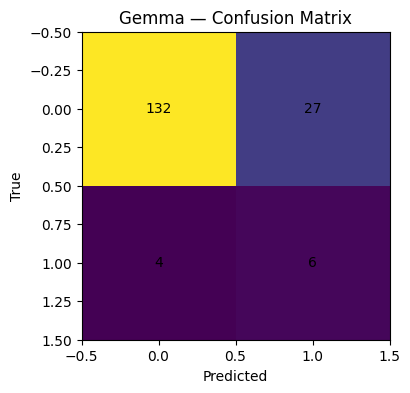

In [12]:
GEMMA_ID = "google/gemma-2-2b"  # or "google/gemma-2b"

gemma_tok = AutoTokenizer.from_pretrained(GEMMA_ID, use_fast=True)
if gemma_tok.pad_token is None:
    gemma_tok.pad_token = gemma_tok.eos_token

# Datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_ds = balance_quantize_and_prepare_data(X_train, y_train, gemma_tok, num_bins=100, max_length=100, test=False)
val_ds   = balance_quantize_and_prepare_data(X_val,   y_val,   gemma_tok, num_bins=100, max_length=100, test=True)

def collate_to_dict(batch):
    # batch is a list of tuples from TensorDataset
    input_ids = torch.stack([b[0] for b in batch])
    attention_mask = torch.stack([b[1] for b in batch])
    labels = torch.stack([b[2] for b in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_to_dict)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate_to_dict)


# 4-bit base model
bnb_config_g = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=GLOBAL_DTYPE if torch.cuda.is_available() else torch.float32,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)


gemma_base = AutoModel.from_pretrained(
    GEMMA_ID,
    device_map="auto" if torch.cuda.is_available() else None,
    quantization_config=bnb_config_g if torch.cuda.is_available() else None,
    torch_dtype=GLOBAL_DTYPE if torch.cuda.is_available() else torch.float32,
    output_hidden_states=True,
)

gemma_model = SoftPromptForDecoder(
    base_model=gemma_base,
    hidden_size=gemma_base.config.hidden_size,
    num_virtual_tokens=20,
    num_labels=2,
    dropout=0.1,
    pooling="mean",
).to(device)

# Weighted loss
num_samples = len(y_train)
num_classes = len(np.unique(y_train))
class_weights = [num_samples / (num_classes * np.sum(np.array(y_train) == c)) for c in range(num_classes)]
model_dtype = next(gemma_model.parameters()).dtype  # likely torch.bfloat16
weight_tensor = torch.tensor(class_weights, device=device, dtype=model_dtype)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)


optimizer = torch.optim.AdamW([p for p in gemma_model.parameters() if p.requires_grad], lr=1e-4, weight_decay=0.0)
num_epochs = 40
total_steps = num_epochs * max(1, len(train_loader))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_f1 = 0.0
start = time.time()
for epoch in range(1, num_epochs+1):
    loss = train_loop(gemma_model, optimizer, scheduler, train_loader, criterion)
    metrics, ys, ps = eval_loop(gemma_model, val_loader)
    print(f"[Gemma][Epoch {epoch}] loss={loss:.4f} | acc={metrics['accuracy']:.3f} f1={metrics['f1']:.3f} rec={metrics['recall']:.3f} prec={metrics['precision']:.3f} auroc={metrics['auroc']:.3f} aupr={metrics['aupr']:.3f}")

print("Time elapsed:", time.time()-start, "s")
plot_confusion(ys, ps, title="Gemma — Confusion Matrix")


### 5. Training for Llama

Original class distribution: Counter({np.int64(0): 648, np.int64(1): 24})
After T-SMOTE class distribution: Counter({np.int64(0): 648, np.int64(1): 648})
Balanced class distribution: Counter({np.int64(0): 648, np.int64(1): 648})


/tmp/ipython-input-4113326302.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(enc["input_ids"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(enc["attention_mask"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(enc["input_ids"], dtype=torch.long)
/tmp/ipython-input-4113326302.py:53: UserWarning: To copy construct from a tensor, it is recommended t

[LLAMA][Epoch 1] loss=0.1628 | acc=0.059 f1=0.112 rec=1.000 prec=0.059 auroc=0.748 aupr=0.441
[LLAMA][Epoch 2] loss=0.1452 | acc=0.059 f1=0.112 rec=1.000 prec=0.059 auroc=0.786 aupr=0.549
[LLAMA][Epoch 3] loss=0.1347 | acc=0.059 f1=0.112 rec=1.000 prec=0.059 auroc=0.777 aupr=0.536
[LLAMA][Epoch 4] loss=0.1267 | acc=0.059 f1=0.112 rec=1.000 prec=0.059 auroc=0.726 aupr=0.486
[LLAMA][Epoch 5] loss=0.1080 | acc=0.160 f1=0.123 rec=1.000 prec=0.066 auroc=0.700 aupr=0.455
[LLAMA][Epoch 6] loss=0.0809 | acc=0.308 f1=0.120 rec=0.800 prec=0.065 auroc=0.701 aupr=0.458
[LLAMA][Epoch 7] loss=0.0812 | acc=0.308 f1=0.120 rec=0.800 prec=0.065 auroc=0.699 aupr=0.468
[LLAMA][Epoch 8] loss=0.0706 | acc=0.219 f1=0.120 rec=0.900 prec=0.064 auroc=0.699 aupr=0.355
[LLAMA][Epoch 9] loss=0.0647 | acc=0.444 f1=0.130 rec=0.700 prec=0.071 auroc=0.704 aupr=0.544
[LLAMA][Epoch 10] loss=0.0577 | acc=0.432 f1=0.127 rec=0.700 prec=0.070 auroc=0.693 aupr=0.543
[LLAMA][Epoch 11] loss=0.0494 | acc=0.432 f1=0.127 rec=0.70

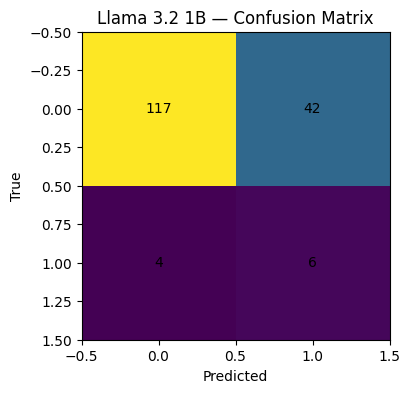

In [14]:

LLAMA_ID = "meta-llama/Llama-3.2-1B"

# Tokenizer
llama_tok = AutoTokenizer.from_pretrained(LLAMA_ID, use_fast=True)
if llama_tok.pad_token is None:
    llama_tok.pad_token = llama_tok.eos_token

# Datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_ds = balance_quantize_and_prepare_data(X_train, y_train, llama_tok, num_bins=100, max_length=100, test=False)
val_ds   = balance_quantize_and_prepare_data(X_val,   y_val,   llama_tok, num_bins=100, max_length=100, test=True)

def collate_to_dict(batch):
    # batch is a list of tuples from TensorDataset
    input_ids = torch.stack([b[0] for b in batch])
    attention_mask = torch.stack([b[1] for b in batch])
    labels = torch.stack([b[2] for b in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_to_dict)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate_to_dict)


# 4-bit base model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=GLOBAL_DTYPE if torch.cuda.is_available() else torch.float32,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

llama_base = AutoModel.from_pretrained(
    LLAMA_ID,
    device_map="auto" if torch.cuda.is_available() else None,
    quantization_config=bnb_config if torch.cuda.is_available() else None,
    torch_dtype=GLOBAL_DTYPE if torch.cuda.is_available() else torch.float32,
    output_hidden_states=True,
)

llama_model = SoftPromptForDecoder(
    base_model=llama_base,
    hidden_size=llama_base.config.hidden_size,
    num_virtual_tokens=20,
    num_labels=2,
    dropout=0.1,
    pooling="mean",
).to(device)

# Weighted loss
num_samples = len(y_train)
num_classes = len(np.unique(y_train))
class_weights = [num_samples / (num_classes * np.sum(np.array(y_train) == c)) for c in range(num_classes)]
model_dtype = next(llama_model.parameters()).dtype  # likely torch.bfloat16
weight_tensor = torch.tensor(class_weights, device=device, dtype=model_dtype)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)


optimizer = torch.optim.AdamW([p for p in llama_model.parameters() if p.requires_grad], lr=1e-4, weight_decay=0.0)
num_epochs = 40
total_steps = num_epochs * max(1, len(train_loader))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_f1 = 0.0
start = time.time()
for epoch in range(1, num_epochs+1):
    loss = train_loop(llama_model, optimizer, scheduler, train_loader, criterion)
    metrics, ys, ps = eval_loop(llama_model, val_loader)
    print(f"[LLAMA][Epoch {epoch}] loss={loss:.4f} | acc={metrics['accuracy']:.3f} f1={metrics['f1']:.3f} rec={metrics['recall']:.3f} prec={metrics['precision']:.3f} auroc={metrics['auroc']:.3f} aupr={metrics['aupr']:.3f}")
print("Time elapsed:", time.time()-start, "s")
plot_confusion(ys, ps, title="Llama 3.2 1B — Confusion Matrix")


# NAB

## BERT

### 0. Install + Imports

In [10]:
%%capture
!pip install transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn matplotlib numpy tslearn imblearn

### 1. Importing data and preprocessing

In [11]:
import json
with open('/content/drive/MyDrive/archive/combined_labels.json', 'r') as file:
    data = json.load(file)
nab_folder = "/content/drive/MyDrive/archive/"
nab_files = [ nab_folder + k for k in data.keys()]

labels = {}
for d, v in data.items():
    new_label = nab_folder + d
    labels[new_label] = v

from datetime import datetime

def label_dataset(csv_path, anomaly_timestamps):
    # Read the CSV file
    try:
        df = pd.read_csv(csv_path, parse_dates=['timestamp'])
    except:
        return pd.DataFrame()

    # Initialize a new column for anomaly labels
    df['anomaly'] = 0

    # Convert anomaly timestamps to datetime objects
    anomaly_datetimes = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in anomaly_timestamps]

    # Label anomalies
    for anomaly_time in anomaly_datetimes:
        df.loc[df['timestamp'] == anomaly_time, 'anomaly'] = 1

    # Save the labeled dataset
    # output_path = csv_path.replace('.csv', '_labeled.csv')
    # df.to_csv(output_path, index=False)
    # print(f"Labeled dataset saved to: {output_path}")
    return df

In [12]:
import pandas as pd
labeled_dfs = {}
# Process each dataset
for csv_path, anomaly_timestamps in labels.items():
    # print(f"Processing: {csv_path}")
    # label_dataset(csv_path, anomaly_timestamps)
    temp = label_dataset(csv_path, anomaly_timestamps)
    if not temp.empty:
        labeled_dfs[csv_path] = label_dataset(csv_path, anomaly_timestamps)
    else:
        continue

In [13]:
def split_sequences(data, sequence_length=50, stride=10):
    """
    Split the data into sequences of specified length.

    :param data: pandas DataFrame with 'values' and 'anomaly' columns
    :param sequence_length: length of each sequence
    :param stride: number of steps to move forward for each new sequence
    :return: list of sequences, where each sequence is a dict with 'values' and 'anomaly' keys
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, stride):
        sequence = {
            'values': data['value'].iloc[i:i+sequence_length].tolist(),
            'anomaly': data['anomaly'].iloc[i:i+sequence_length].tolist()
        }
        sequences.append(sequence)
    return sequences

def create_labeled_sequences(sequences):
    """
    Label each sequence based on whether it contains an anomaly.

    :param sequences: list of sequences
    :return: list of labeled sequences, where each is a dict with 'values', 'anomaly', and 'contains_anomaly' keys
    """
    labeled_sequences = []
    for seq in sequences:
        labeled_seq = seq.copy()
        labeled_seq['contains_anomaly'] = 1 if sum(seq['anomaly']) > 0 else 0
        labeled_sequences.append(labeled_seq)
    return labeled_sequences

folders_with_anomalies = ["artificialWithAnomaly",
                          "realAWSCloudwatch",
                          "realAdExchange",
                          "realKnownCause",
                          "realTraffic",
                          "realTweets"]
artificialWithAnomaly = [k for k in labeled_dfs.keys() if "artificialWithAnomaly" in k]
realAWSCloudwatch = [k for k in labeled_dfs.keys() if "realAWSCloudwatch" in k]
realAdExchange = [k for k in labeled_dfs.keys() if "realAdExchange" in k]
realKnownCause = [k for k in labeled_dfs.keys() if "realKnownCause" in k]
realTraffic = [k for k in labeled_dfs.keys() if "realTraffic" in k]
realTweets = [k for k in labeled_dfs.keys() if "realTweets" in k]

In [14]:
realAWSCloudwatch_dfs = {}
for i in range(len(realAWSCloudwatch)):
  labeled_dfs[realAWSCloudwatch[i]] = labeled_dfs[realAWSCloudwatch[i]].reset_index(drop=True)
  temp = labeled_dfs[realAWSCloudwatch[i]].drop(columns=['timestamp'])
  temp = split_sequences(temp)
  temp = create_labeled_sequences(temp)
  realAWSCloudwatch_dfs[realAWSCloudwatch[i]] = pd.DataFrame(temp)
current_dataset = realAWSCloudwatch_dfs

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Data Preparation
def prepare_data_for_lstm(X, y, sequence_length=10):
    # Convert to numpy arrays
    X = np.array([np.array(x) for x in X], dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    # Print original class distribution
    print("Original class distribution:", Counter(y))

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype(np.float32)

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
    X_resampled = X_resampled.astype(np.float32)
    y_resampled = y_resampled.astype(np.int64)

    # Print balanced class distribution
    print("Balanced class distribution:", Counter(y_resampled))

    # Create sequences
    X_sequences = []
    y_sequences = []
    for i in range(len(X_resampled) - sequence_length + 1):
        X_sequences.append(X_resampled[i:i+sequence_length])
        y_sequences.append(y_resampled[i+sequence_length-1])

    # Convert to tensors
    X_tensor = torch.FloatTensor(X_sequences)
    y_tensor = torch.LongTensor(y_sequences)

    return X_tensor, y_tensor
final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

sequence_length = 10  # Adjust based on your time series characteristics
X_train_seq, y_train_seq = prepare_data_for_lstm(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = prepare_data_for_lstm(X_val, y_val, sequence_length)

Original class distribution: Counter({np.int64(0): 4580, np.int64(1): 112})
Balanced class distribution: Counter({np.int64(0): 4580, np.int64(1): 4580})


/tmp/ipython-input-560832627.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_tensor = torch.FloatTensor(X_sequences)


Original class distribution: Counter({np.int64(0): 1968, np.int64(1): 43})
Balanced class distribution: Counter({np.int64(0): 1968, np.int64(1): 1968})


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score
)

### 2. Addressing class imbalanceness and quantization

In [15]:
final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
base_model = DistilBertModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def balance_quantize_and_prepare_data(X, y, tokenizer, num_bins=100, max_length=128):
    # Convert X to a 2D numpy array
    X = np.array([np.array(x) for x in X], dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    print("Original class distribution:", Counter(y))

    # Balance with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_resampled = X_resampled.astype(np.float32)
    y_resampled = y_resampled.astype(np.int64)

    print("Balanced class distribution:", Counter(y_resampled))

    # Quantize each feature separately
    X_quantized = []
    for feature in X_resampled.T:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kbd = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
            quantized_feature = kbd.fit_transform(feature.reshape(-1, 1)).flatten()
            X_quantized.append([f"Q{int(val)}" for val in quantized_feature])

    # Transpose back
    X_quantized = list(map(list, zip(*X_quantized)))

    # Join quantized features into strings
    X_quantized_str = [' '.join(row) for row in X_quantized]

    # Scale the original values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)

    # Combine quantized strings with scaled values
    X_combined = [f"{q_str} {' '.join(map(str, scaled))}" for q_str, scaled in zip(X_quantized_str, X_scaled)]

    # Tokenize
    encodings = tokenizer(X_combined, truncation=True, padding=True, max_length=max_length)

    # Tensors
    input_ids = torch.tensor(encodings['input_ids'], dtype=torch.long)
    attention_mask = torch.tensor(encodings['attention_mask'], dtype=torch.long)
    labels = torch.tensor(y_resampled, dtype=torch.long)

    return TensorDataset(input_ids, attention_mask, labels)

### 3. Soft Prompt Model

In [17]:
class SoftPrompt(nn.Module):
    def __init__(self, num_virtual_tokens, embedding_size):
        super().__init__()
        # Learnable soft prompt embeddings
        self.soft_prompt = nn.Parameter(
            torch.randn(1, num_virtual_tokens, embedding_size)
        )

    def forward(self, batch_size):
        # Expand prompt for batch
        return self.soft_prompt.expand(batch_size, -1, -1)


class SoftPromptModel(nn.Module):
    def __init__(self, base_model, num_virtual_tokens, num_labels):
        super().__init__()
        self.base_model = base_model
        self.soft_prompt = SoftPrompt(num_virtual_tokens, base_model.config.hidden_size)

        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

        self.num_virtual_tokens = num_virtual_tokens

    def forward(self, input_ids, attention_mask):
        batch_size = input_ids.shape[0]

        # Get soft prompt embeddings
        soft_prompt_embeds = self.soft_prompt(batch_size)

        # Token embeddings from base model
        input_embeds = self.base_model.embeddings.word_embeddings(input_ids)

        # Concatenate soft prompt + inputs
        inputs_embeds = torch.cat([soft_prompt_embeds, input_embeds], dim=1)

        # Adjust attention mask for soft prompts
        soft_mask = torch.ones(
            (batch_size, self.num_virtual_tokens), dtype=torch.long, device=attention_mask.device
        )
        extended_attention_mask = torch.cat([soft_mask, attention_mask], dim=1)

        # Forward through base model
        outputs = self.base_model(
            inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask
        )

        # Take the hidden state of the first real token (after soft prompts)
        pooled_output = outputs.last_hidden_state[:, self.num_virtual_tokens, :]

        # Classification logits
        logits = self.classifier(pooled_output)
        return logits

### Training

In [18]:
# -----------------------------
# Datasets & loaders
# -----------------------------
train_dataset = balance_quantize_and_prepare_data(X_train, y_train, tokenizer)
val_dataset   = balance_quantize_and_prepare_data(X_val,   y_val,   tokenizer)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# -----------------------------
# Model, loss, optimizer, sched
# -----------------------------
num_virtual_tokens = 20
num_labels = 2
model = SoftPromptModel(base_model, num_virtual_tokens, num_labels).to(device)

num_samples = len(y_train)
num_classes = len(np.unique(y_train))
class_weights = [num_samples / (num_classes * np.sum(np.array(y_train) == c)) for c in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
num_epochs = 40
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

# -----------------------------
# Training + per-epoch metrics
# -----------------------------
history = {
    "loss": [],
    "accuracy": [],
    "f1": [],
    "recall": [],
    "precision": [],
    "auroc": [],
    "aupr": [],
}

for epoch in range(1, num_epochs + 1):
    # --- Train ---
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad(set_to_none=True)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / max(len(train_loader), 1)
    history["loss"].append(avg_loss)

    # --- Validate & metrics ---
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    pre = precision_score(all_labels, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")
    apr = average_precision_score(all_labels, all_probs)

    history["accuracy"].append(acc)
    history["f1"].append(f1)
    history["recall"].append(rec)
    history["precision"].append(pre)
    history["auroc"].append(auc)
    history["aupr"].append(apr)

    print(
        f"Epoch {epoch:03d}/{num_epochs} | "
        f"loss={avg_loss:.4f} | acc={acc:.4f} f1={f1:.4f} rec={rec:.4f} pre={pre:.4f} "
        f"auroc={auc:.4f} aupr={apr:.4f}"
    )

# -----------------------------
# Final evaluation on val set
# -----------------------------
print("\n=== Final Validation Metrics ===")
print(f"Accuracy:  {history['accuracy'][-1]:.4f}")
print(f"F1 Score:  {history['f1'][-1]:.4f}")
print(f"Recall:    {history['recall'][-1]:.4f}")
print(f"Precision: {history['precision'][-1]:.4f}")
print(f"AUROC:     {history['auroc'][-1]:.4f}")
print(f"AUPR:      {history['aupr'][-1]:.4f}")

Original class distribution: Counter({np.int64(0): 5238, np.int64(1): 124})
Balanced class distribution: Counter({np.int64(0): 5238, np.int64(1): 5238})
Original class distribution: Counter({np.int64(0): 1310, np.int64(1): 31})
Balanced class distribution: Counter({np.int64(0): 1310, np.int64(1): 1310})
Epoch 001/40 | loss=0.1074 | acc=0.5733 f1=0.7004 rec=0.9977 pre=0.5396 auroc=0.6509 aupr=0.6367
Epoch 002/40 | loss=0.0720 | acc=0.5656 f1=0.6607 rec=0.8458 pre=0.5421 auroc=0.5684 aupr=0.5357
Epoch 003/40 | loss=0.0540 | acc=0.5546 f1=0.6680 rec=0.8962 pre=0.5324 auroc=0.5871 aupr=0.5391
Epoch 004/40 | loss=0.0421 | acc=0.5439 f1=0.6678 rec=0.9168 pre=0.5251 auroc=0.5860 aupr=0.5512
Epoch 005/40 | loss=0.0333 | acc=0.5462 f1=0.6234 rec=0.7511 pre=0.5328 auroc=0.5442 aupr=0.5026
Epoch 006/40 | loss=0.0257 | acc=0.5546 f1=0.6458 rec=0.8122 pre=0.5360 auroc=0.5725 aupr=0.5267
Epoch 007/40 | loss=0.0248 | acc=0.5469 f1=0.6216 rec=0.7443 pre=0.5337 auroc=0.5714 aupr=0.5221
Epoch 008/40 | l

## Llama 3 & Gemma 2


### 0. Install + Imports

In [19]:
%%capture
!pip install transformers peft accelerate datasets bitsandbytes torch pandas scikit-learn matplotlib numpy tslearn imblearn

### 1. Importing data and preprocessing

In [20]:
import json
with open('/content/drive/MyDrive/archive/combined_labels.json', 'r') as file:
    data = json.load(file)
nab_folder = "/content/drive/MyDrive/archive/"
nab_files = [ nab_folder + k for k in data.keys()]

labels = {}
for d, v in data.items():
    new_label = nab_folder + d
    labels[new_label] = v

from datetime import datetime

def label_dataset(csv_path, anomaly_timestamps):
    # Read the CSV file
    try:
        df = pd.read_csv(csv_path, parse_dates=['timestamp'])
    except:
        return pd.DataFrame()

    # Initialize a new column for anomaly labels
    df['anomaly'] = 0

    # Convert anomaly timestamps to datetime objects
    anomaly_datetimes = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in anomaly_timestamps]

    # Label anomalies
    for anomaly_time in anomaly_datetimes:
        df.loc[df['timestamp'] == anomaly_time, 'anomaly'] = 1

    # Save the labeled dataset
    # output_path = csv_path.replace('.csv', '_labeled.csv')
    # df.to_csv(output_path, index=False)
    # print(f"Labeled dataset saved to: {output_path}")
    return df

In [21]:
import pandas as pd
labeled_dfs = {}
# Process each dataset
for csv_path, anomaly_timestamps in labels.items():
    # print(f"Processing: {csv_path}")
    # label_dataset(csv_path, anomaly_timestamps)
    temp = label_dataset(csv_path, anomaly_timestamps)
    if not temp.empty:
        labeled_dfs[csv_path] = label_dataset(csv_path, anomaly_timestamps)
    else:
        continue

In [22]:
def split_sequences(data, sequence_length=50, stride=10):
    """
    Split the data into sequences of specified length.

    :param data: pandas DataFrame with 'values' and 'anomaly' columns
    :param sequence_length: length of each sequence
    :param stride: number of steps to move forward for each new sequence
    :return: list of sequences, where each sequence is a dict with 'values' and 'anomaly' keys
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, stride):
        sequence = {
            'values': data['value'].iloc[i:i+sequence_length].tolist(),
            'anomaly': data['anomaly'].iloc[i:i+sequence_length].tolist()
        }
        sequences.append(sequence)
    return sequences

def create_labeled_sequences(sequences):
    """
    Label each sequence based on whether it contains an anomaly.

    :param sequences: list of sequences
    :return: list of labeled sequences, where each is a dict with 'values', 'anomaly', and 'contains_anomaly' keys
    """
    labeled_sequences = []
    for seq in sequences:
        labeled_seq = seq.copy()
        labeled_seq['contains_anomaly'] = 1 if sum(seq['anomaly']) > 0 else 0
        labeled_sequences.append(labeled_seq)
    return labeled_sequences

folders_with_anomalies = ["artificialWithAnomaly",
                          "realAWSCloudwatch",
                          "realAdExchange",
                          "realKnownCause",
                          "realTraffic",
                          "realTweets"]
artificialWithAnomaly = [k for k in labeled_dfs.keys() if "artificialWithAnomaly" in k]
realAWSCloudwatch = [k for k in labeled_dfs.keys() if "realAWSCloudwatch" in k]
realAdExchange = [k for k in labeled_dfs.keys() if "realAdExchange" in k]
realKnownCause = [k for k in labeled_dfs.keys() if "realKnownCause" in k]
realTraffic = [k for k in labeled_dfs.keys() if "realTraffic" in k]
realTweets = [k for k in labeled_dfs.keys() if "realTweets" in k]

In [23]:
realAWSCloudwatch_dfs = {}
for i in range(len(realAWSCloudwatch)):
  labeled_dfs[realAWSCloudwatch[i]] = labeled_dfs[realAWSCloudwatch[i]].reset_index(drop=True)
  temp = labeled_dfs[realAWSCloudwatch[i]].drop(columns=['timestamp'])
  temp = split_sequences(temp)
  temp = create_labeled_sequences(temp)
  realAWSCloudwatch_dfs[realAWSCloudwatch[i]] = pd.DataFrame(temp)
current_dataset = realAWSCloudwatch_dfs

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
from torch.optim.lr_scheduler import ReduceLROnPlateau

def prepare_data_for_lstm(X, y, sequence_length=10):
    # Convert to numpy arrays
    X = np.array([np.array(x) for x in X], dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    # Print original class distribution
    print("Original class distribution:", Counter(y))

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype(np.float32)

    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
    X_resampled = X_resampled.astype(np.float32)
    y_resampled = y_resampled.astype(np.int64)

    # Print balanced class distribution
    print("Balanced class distribution:", Counter(y_resampled))

    # Create sequences
    X_sequences = []
    y_sequences = []
    for i in range(len(X_resampled) - sequence_length + 1):
        X_sequences.append(X_resampled[i:i+sequence_length])
        y_sequences.append(y_resampled[i+sequence_length-1])

    # Convert to tensors
    X_tensor = torch.FloatTensor(X_sequences)
    y_tensor = torch.LongTensor(y_sequences)

    return X_tensor, y_tensor
final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

sequence_length = 10  # Adjust based on your time series characteristics
X_train_seq, y_train_seq = prepare_data_for_lstm(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = prepare_data_for_lstm(X_val, y_val, sequence_length)

Original class distribution: Counter({np.int64(0): 4580, np.int64(1): 112})
Balanced class distribution: Counter({np.int64(0): 4580, np.int64(1): 4580})
Original class distribution: Counter({np.int64(0): 1968, np.int64(1): 43})
Balanced class distribution: Counter({np.int64(0): 1968, np.int64(1): 1968})


In [25]:
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score
)

### 2. Addressing class imbalanceness and quantization

In [26]:
final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
base_model = DistilBertModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def balance_quantize_and_prepare_data(X, y, tokenizer, num_bins=100, max_length=128):
    # Convert X to a 2D numpy array
    X = np.array([np.array(x) for x in X], dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    print("Original class distribution:", Counter(y))

    # Balance with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_resampled = X_resampled.astype(np.float32)
    y_resampled = y_resampled.astype(np.int64)

    print("Balanced class distribution:", Counter(y_resampled))

    # Quantize each feature separately
    X_quantized = []
    for feature in X_resampled.T:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kbd = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
            quantized_feature = kbd.fit_transform(feature.reshape(-1, 1)).flatten()
            X_quantized.append([f"Q{int(val)}" for val in quantized_feature])

    # Transpose back
    X_quantized = list(map(list, zip(*X_quantized)))

    # Join quantized features into strings
    X_quantized_str = [' '.join(row) for row in X_quantized]

    # Scale the original values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)

    # Combine quantized strings with scaled values
    X_combined = [f"{q_str} {' '.join(map(str, scaled))}" for q_str, scaled in zip(X_quantized_str, X_scaled)]

    # Tokenize
    encodings = tokenizer(X_combined, truncation=True, padding=True, max_length=max_length)

    # Tensors
    input_ids = torch.tensor(encodings['input_ids'], dtype=torch.long)
    attention_mask = torch.tensor(encodings['attention_mask'], dtype=torch.long)
    labels = torch.tensor(y_resampled, dtype=torch.long)

    return TensorDataset(input_ids, attention_mask, labels)

### 3. Training for Gemma

In [27]:
import math, time, random, numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import train_test_split

final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------
# 1) Config
# --------------------
TARGET_MODEL   = "gemma"       # "llama" or "gemma"
NUM_BINS       = 100           # quantization bins
BIN_STRATEGY   = "uniform"    # "quantile" or "uniform"
PROMPT_TOKENS  = 20            # number of soft prompt tokens
POOL_TAIL_K    = 8             # mean-pool last K real tokens
MAX_LENGTH     = 128
BATCH_SIZE     = 16
NUM_EPOCHS     = 40
LR             = 5e-4          # conservative for stability
WARMUP_STEPS   = 100
WEIGHT_DECAY   = 0.0

MODEL_ID = {
    "llama": "meta-llama/Llama-3.2-1B",
    "gemma": "google/gemma-2-2b",
}[TARGET_MODEL]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compute_dtype = torch.float32  # stability first

rng = np.random.default_rng(42)
random.seed(42)
torch.manual_seed(42)

# --------------------
# 2) Label normalization (handles text labels like "No abnormality")
# --------------------
def to_int_labels(y_like):
    if isinstance(y_like.iloc[0] if hasattr(y_like, "iloc") else y_like[0], (int, np.integer)):
        return np.asarray(y_like, dtype=np.int64)
    out = []
    for v in list(y_like):
        s = str(v).lower()
        out.append(0 if "no abnormality" in s else 1)
    return np.asarray(out, dtype=np.int64)

y_train_np = to_int_labels(y_train)
y_val_np   = to_int_labels(y_val)
num_labels = int(len(set(list(y_train_np) + list(y_val_np))))
assert num_labels in (2, 3), "Only binary or 3-class supported."

# --------------------
# 3) Quantization (fit on TRAIN only) + Balance (oversample train)
# --------------------
def fit_binner_on_train(X_list, n_bins=NUM_BINS, strategy=BIN_STRATEGY):
    flat = np.concatenate([np.asarray(x, dtype=np.float32).ravel() for x in X_list])
    flat = np.nan_to_num(flat, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
    binner = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
    binner.fit(flat)
    return binner

def apply_binner(binner, seq):
    v = np.asarray(seq, dtype=np.float32).ravel()
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
    q = binner.transform(v).astype(np.int64).ravel()
    return np.clip(q, 0, NUM_BINS - 1)

def quantize_dataset(binner, X_list):
    return [apply_binner(binner, s) for s in X_list]

def oversample_to_balance(X_list, y_array):
    y_array = np.asarray(y_array, dtype=np.int64)
    classes, counts = np.unique(y_array, return_counts=True)
    max_count = counts.max()
    X_bal, y_bal = [], []
    for c in classes:
        idx = np.where(y_array == c)[0].tolist()
        reps = max_count // len(idx)
        rem  = max_count %  len(idx)
        full = idx * reps + (rng.choice(idx, size=rem, replace=True).tolist() if rem else [])
        for i in full:
            X_bal.append(X_list[i])
            y_bal.append(int(c))
    order = np.arange(len(X_bal)); rng.shuffle(order)
    return [X_bal[i] for i in order], np.asarray([y_bal[i] for i in order], dtype=np.int64)

def ids_to_text(seq_ids):
    return " ".join(str(int(t)) for t in seq_ids)

binner     = fit_binner_on_train(X_train)
X_train_q  = quantize_dataset(binner, X_train)
X_val_q    = quantize_dataset(binner, X_val)
X_train_bal, y_train_bal = oversample_to_balance(X_train_q, y_train_np)

train_texts = [ids_to_text(s) for s in X_train_bal]
val_texts   = [ids_to_text(s) for s in X_val_q]

print("Train (orig) pos rate:", float((y_train_np == 1).mean()))
print("Train (balanced) size:", len(y_train_bal), "pos rate:", float((y_train_bal == 1).mean()))
print("Val size:", len(y_val_np), "pos rate:", float((y_val_np == 1).mean()))

# --------------------
# 4) Tokenizer & Backbone
# --------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

base_model = AutoModel.from_pretrained(
    MODEL_ID,
    torch_dtype=compute_dtype,
    low_cpu_mem_usage=True,
)
base_model.to(device).eval()

# --------------------
# 5) Datasets / Loaders
# --------------------
class TextClsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts  = list(texts)
        self.labels = np.asarray(labels, dtype=np.int64)
    def __len__(self): return len(self.texts)
    def __getitem__(self, i): return self.texts[i], int(self.labels[i])

def collate(batch):
    texts, labels = zip(*batch)
    enc = tokenizer(list(texts), padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long),
    }

train_loader = DataLoader(TextClsDataset(train_texts, y_train_bal), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(TextClsDataset(val_texts,   y_val_np),    batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

# --------------------
# 6) Soft-Prompt + Classifier (stable forward)
# --------------------
class SoftPromptClassifier(nn.Module):
    def __init__(self, base_model, num_virtual_tokens, num_labels, dropout=0.1, pooling="mean"):
        super().__init__()
        self.base_model = base_model
        for p in self.base_model.parameters():
            p.requires_grad = False  # freeze backbone

        self.hidden_size = base_model.config.hidden_size
        self.num_virtual_tokens = num_virtual_tokens

        # soft prompt initialized like embeddings
        prompt = torch.randn(1, num_virtual_tokens, self.hidden_size) * 0.02
        self.soft_prompt = nn.Parameter(prompt)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_size, num_labels)

        self.pooling = pooling  # "mean", "first", "last"
        self.embed = base_model.get_input_embeddings()

    def forward(self, input_ids, attention_mask=None, labels=None):
        B, T = input_ids.shape
        token_embeds = self.embed(input_ids)  # [B,T,H]
        sp = self.soft_prompt.expand(B, -1, -1)  # [B,P,H]
        inputs_embeds = torch.cat([sp, token_embeds], dim=1)

        if attention_mask is None:
            attention_mask = torch.ones((B, T), device=input_ids.device, dtype=torch.long)
        sp_mask = torch.ones((B, self.num_virtual_tokens), device=attention_mask.device, dtype=attention_mask.dtype)
        attn_mask = torch.cat([sp_mask, attention_mask], dim=1)

        outputs = self.base_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attn_mask,
            output_hidden_states=True,
            use_cache=False,
        )
        last_hidden = outputs.hidden_states[-1]  # [B,P+T,H]

        # --- pooling ---
        if self.pooling == "mean":
            real_mask = attn_mask[:, self.num_virtual_tokens:].unsqueeze(-1)  # [B,T,1]
            summed = (last_hidden[:, self.num_virtual_tokens:, :] * real_mask).sum(1)
            counts = real_mask.sum(1).clamp(min=1)
            pooled = summed / counts
        elif self.pooling == "first":
            pooled = last_hidden[:, self.num_virtual_tokens, :]
        else:  # "last"
            lengths = attention_mask.sum(1) - 1
            pooled = last_hidden[torch.arange(B, device=lengths.device), self.num_virtual_tokens + lengths, :]

        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits}


model = SoftPromptClassifier(base_model, PROMPT_TOKENS, num_labels).to(device)

# Initialize classifier bias to dataset prior (original train, before balancing)
with torch.no_grad():
    if num_labels == 2:
        pos_rate = float((np.asarray(y_train_np) == 1).mean())
        pos_rate = min(max(pos_rate, 1e-6), 1 - 1e-6)
        prior_logit = np.log(pos_rate / (1 - pos_rate))
        model.classifier.bias.zero_()
        # symmetric init to nudge logits rather than hard-code a threshold
        model.classifier.bias[1] = torch.tensor(prior_logit, dtype=torch.float32, device=model.classifier.bias.device)
        model.classifier.bias[0] = torch.tensor(-prior_logit, dtype=torch.float32, device=model.classifier.bias.device)

# --------------------
# 7) Optimizer / Scheduler
# --------------------
trainable = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable, lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = NUM_EPOCHS * max(1, math.ceil(len(train_loader)))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

# --------------------
# 8) Train / Eval (sanitized metrics)
# --------------------
@torch.no_grad()
def evaluate():
    model.eval()
    ys, ps, probs_pos = [], [], []
    for batch in val_loader:
        input_ids  = batch["input_ids"].to(device)
        attn_mask  = batch["attention_mask"].to(device)
        labels     = batch["labels"].to(device)

        out = model(input_ids=input_ids, attention_mask=attn_mask)
        logits = out["logits"].to(torch.float32)

        # sanitize logits to avoid NaNs in metrics
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        preds = torch.argmax(logits, dim=-1)
        ys.extend(labels.tolist())
        ps.extend(preds.tolist())

        if num_labels == 2:
            m = torch.amax(logits, dim=-1, keepdim=True)
            ex = torch.exp((logits - m))
            denom = ex.sum(dim=-1, keepdim=True).clamp_min(1e-12)
            prob1 = (ex / denom)[:, 1]
            prob1 = torch.where(torch.isfinite(prob1), prob1, torch.zeros_like(prob1))
            probs_pos.extend(prob1.cpu().numpy().tolist())

    acc  = accuracy_score(ys, ps)
    f1   = f1_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)
    rec  = recall_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)
    prec = precision_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)

    if num_labels == 2 and len(set(ys)) > 1:
        probs_np = np.asarray(probs_pos, dtype=np.float64)
        if np.isfinite(probs_np).all():
            try:  auroc = roc_auc_score(ys, probs_np)
            except ValueError: auroc = float("nan")
            try:  aupr  = average_precision_score(ys, probs_np)
            except ValueError: aupr = float("nan")
        else:
            auroc, aupr = float("nan"), float("nan")
    else:
        auroc, aupr = float("nan"), float("nan")

    return {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec, "auroc": auroc, "aupr": aupr}

def train_one_epoch():
    model.train()
    total_loss, bad_batches = 0.0, 0
    for batch in train_loader:
        input_ids  = batch["input_ids"].to(device)
        attn_mask  = batch["attention_mask"].to(device)
        labels     = batch["labels"].to(device)

        out = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = out["loss"]

        if loss is None or not torch.isfinite(loss):
            bad_batches += 1
            continue

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable, 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += float(loss.item())

    if bad_batches:
        print(f"[warn] skipped {bad_batches} non-finite batches")
    denom = max(1, len(train_loader) - bad_batches)
    return total_loss / denom

start = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss = train_one_epoch()
    metrics = evaluate()
    print(f"[{TARGET_MODEL.upper()}][Epoch {epoch}] "
          f"loss={tr_loss:.4f} | acc={metrics['accuracy']:.3f} f1={metrics['f1']:.3f} "
          f"rec={metrics['recall']:.3f} prec={metrics['precision']:.3f} "
          f"auroc={metrics['auroc']:.3f} aupr={metrics['aupr']:.3f}")
print(f"Done in {time.time()-start:.1f}s")


Train (orig) pos rate: 0.023125699365908244
Train (balanced) size: 10476 pos rate: 0.5
Val size: 1341 pos rate: 0.023117076808351976


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[GEMMA][Epoch 1] loss=0.8371 | acc=0.063 f1=0.047 rec=1.000 prec=0.024 auroc=0.508 aupr=0.096
[GEMMA][Epoch 2] loss=0.7233 | acc=0.387 f1=0.049 rec=0.677 prec=0.025 auroc=0.589 aupr=0.125
[GEMMA][Epoch 3] loss=0.7100 | acc=0.974 f1=0.186 rec=0.129 prec=0.333 auroc=0.580 aupr=0.127
[GEMMA][Epoch 4] loss=0.6845 | acc=0.975 f1=0.227 rec=0.161 prec=0.385 auroc=0.622 aupr=0.159
[GEMMA][Epoch 5] loss=0.6778 | acc=0.975 f1=0.227 rec=0.161 prec=0.385 auroc=0.638 aupr=0.187
[GEMMA][Epoch 6] loss=0.6770 | acc=0.978 f1=0.211 rec=0.129 prec=0.571 auroc=0.604 aupr=0.178
[GEMMA][Epoch 7] loss=0.6621 | acc=0.976 f1=0.273 rec=0.194 prec=0.462 auroc=0.611 aupr=0.206
[GEMMA][Epoch 8] loss=0.6616 | acc=0.077 f1=0.048 rec=1.000 prec=0.024 auroc=0.607 aupr=0.214
[GEMMA][Epoch 9] loss=0.6556 | acc=0.976 f1=0.238 rec=0.161 prec=0.455 auroc=0.576 aupr=0.184
[GEMMA][Epoch 10] loss=0.6562 | acc=0.979 f1=0.222 rec=0.129 prec=0.800 auroc=0.580 aupr=0.179
[GEMMA][Epoch 11] loss=0.6436 | acc=0.980 f1=0.229 rec=0.12

KeyboardInterrupt: 

### 3. Training for Llama


In [28]:
# === LAST CELL: Quantize + Balance + Stable Soft Prompts on LLAMA/GEMMA ===
import math, time, random, numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import train_test_split

final_df = pd.concat(current_dataset.values(), ignore_index=True)
X = final_df['values']
y = final_df['contains_anomaly']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------
# 1) Config
# --------------------
TARGET_MODEL   = "llama"       # "llama" or "gemma"
NUM_BINS       = 100           # quantization bins
BIN_STRATEGY   = "uniform"    # "quantile" or "uniform"
PROMPT_TOKENS  = 20            # number of soft prompt tokens
POOL_TAIL_K    = 8             # mean-pool last K real tokens
MAX_LENGTH     = 128
BATCH_SIZE     = 16
NUM_EPOCHS     = 5
LR             = 1e-4          # conservative for stability
WARMUP_STEPS   = 100
WEIGHT_DECAY   = 0.0

MODEL_ID = {
    "llama": "meta-llama/Llama-3.2-1B",
    "gemma": "google/gemma-2-2b",
}[TARGET_MODEL]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compute_dtype = torch.float32  # stability first

rng = np.random.default_rng(42)
random.seed(42)
torch.manual_seed(42)

# --------------------
# 2) Label normalization (handles text labels like "No abnormality")
# --------------------
def to_int_labels(y_like):
    if isinstance(y_like.iloc[0] if hasattr(y_like, "iloc") else y_like[0], (int, np.integer)):
        return np.asarray(y_like, dtype=np.int64)
    out = []
    for v in list(y_like):
        s = str(v).lower()
        out.append(0 if "no abnormality" in s else 1)
    return np.asarray(out, dtype=np.int64)

y_train_np = to_int_labels(y_train)
y_val_np   = to_int_labels(y_val)
num_labels = int(len(set(list(y_train_np) + list(y_val_np))))
assert num_labels in (2, 3), "Only binary or 3-class supported."

# --------------------
# 3) Quantization (fit on TRAIN only) + Balance (oversample train)
# --------------------
def fit_binner_on_train(X_list, n_bins=NUM_BINS, strategy=BIN_STRATEGY):
    flat = np.concatenate([np.asarray(x, dtype=np.float32).ravel() for x in X_list])
    flat = np.nan_to_num(flat, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
    binner = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
    binner.fit(flat)
    return binner

def apply_binner(binner, seq):
    v = np.asarray(seq, dtype=np.float32).ravel()
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0).reshape(-1, 1)
    q = binner.transform(v).astype(np.int64).ravel()
    return np.clip(q, 0, NUM_BINS - 1)

def quantize_dataset(binner, X_list):
    return [apply_binner(binner, s) for s in X_list]

def oversample_to_balance(X_list, y_array):
    y_array = np.asarray(y_array, dtype=np.int64)
    classes, counts = np.unique(y_array, return_counts=True)
    max_count = counts.max()
    X_bal, y_bal = [], []
    for c in classes:
        idx = np.where(y_array == c)[0].tolist()
        reps = max_count // len(idx)
        rem  = max_count %  len(idx)
        full = idx * reps + (rng.choice(idx, size=rem, replace=True).tolist() if rem else [])
        for i in full:
            X_bal.append(X_list[i])
            y_bal.append(int(c))
    order = np.arange(len(X_bal)); rng.shuffle(order)
    return [X_bal[i] for i in order], np.asarray([y_bal[i] for i in order], dtype=np.int64)

def ids_to_text(seq_ids):
    return " ".join(str(int(t)) for t in seq_ids)

binner     = fit_binner_on_train(X_train)
X_train_q  = quantize_dataset(binner, X_train)
X_val_q    = quantize_dataset(binner, X_val)
X_train_bal, y_train_bal = oversample_to_balance(X_train_q, y_train_np)

train_texts = [ids_to_text(s) for s in X_train_bal]
val_texts   = [ids_to_text(s) for s in X_val_q]

print("Train (orig) pos rate:", float((y_train_np == 1).mean()))
print("Train (balanced) size:", len(y_train_bal), "pos rate:", float((y_train_bal == 1).mean()))
print("Val size:", len(y_val_np), "pos rate:", float((y_val_np == 1).mean()))

# --------------------
# 4) Tokenizer & Backbone
# --------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

base_model = AutoModel.from_pretrained(
    MODEL_ID,
    torch_dtype=compute_dtype,
    low_cpu_mem_usage=True,
)
base_model.to(device).eval()

# --------------------
# 5) Datasets / Loaders
# --------------------
class TextClsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts  = list(texts)
        self.labels = np.asarray(labels, dtype=np.int64)
    def __len__(self): return len(self.texts)
    def __getitem__(self, i): return self.texts[i], int(self.labels[i])

def collate(batch):
    texts, labels = zip(*batch)
    enc = tokenizer(list(texts), padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long),
    }

train_loader = DataLoader(TextClsDataset(train_texts, y_train_bal), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(TextClsDataset(val_texts,   y_val_np),    batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

# --------------------
# 6) Soft-Prompt + Classifier (stable forward)
# --------------------
class SoftPromptClassifier(nn.Module):
    def __init__(self, base_model, num_virtual_tokens, num_labels, dropout=0.1, pooling="mean"):
        super().__init__()
        self.base_model = base_model
        for p in self.base_model.parameters():
            p.requires_grad = False  # freeze backbone

        self.hidden_size = base_model.config.hidden_size
        self.num_virtual_tokens = num_virtual_tokens

        # soft prompt initialized like embeddings
        prompt = torch.randn(1, num_virtual_tokens, self.hidden_size) * 0.02
        self.soft_prompt = nn.Parameter(prompt)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_size, num_labels)

        self.pooling = pooling  # "mean", "first", "last"
        self.embed = base_model.get_input_embeddings()

    def forward(self, input_ids, attention_mask=None, labels=None):
        B, T = input_ids.shape
        token_embeds = self.embed(input_ids)  # [B,T,H]
        sp = self.soft_prompt.expand(B, -1, -1)  # [B,P,H]
        inputs_embeds = torch.cat([sp, token_embeds], dim=1)

        if attention_mask is None:
            attention_mask = torch.ones((B, T), device=input_ids.device, dtype=torch.long)
        sp_mask = torch.ones((B, self.num_virtual_tokens), device=attention_mask.device, dtype=attention_mask.dtype)
        attn_mask = torch.cat([sp_mask, attention_mask], dim=1)

        outputs = self.base_model(
            inputs_embeds=inputs_embeds,
            attention_mask=attn_mask,
            output_hidden_states=True,
            use_cache=False,
        )
        last_hidden = outputs.hidden_states[-1]  # [B,P+T,H]

        # --- pooling ---
        if self.pooling == "mean":
            real_mask = attn_mask[:, self.num_virtual_tokens:].unsqueeze(-1)  # [B,T,1]
            summed = (last_hidden[:, self.num_virtual_tokens:, :] * real_mask).sum(1)
            counts = real_mask.sum(1).clamp(min=1)
            pooled = summed / counts
        elif self.pooling == "first":
            pooled = last_hidden[:, self.num_virtual_tokens, :]
        else:  # "last"
            lengths = attention_mask.sum(1) - 1
            pooled = last_hidden[torch.arange(B, device=lengths.device), self.num_virtual_tokens + lengths, :]

        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits}


model = SoftPromptClassifier(base_model, PROMPT_TOKENS, num_labels).to(device)

# Initialize classifier bias to dataset prior (original train, before balancing)
with torch.no_grad():
    if num_labels == 2:
        pos_rate = float((np.asarray(y_train_np) == 1).mean())
        pos_rate = min(max(pos_rate, 1e-6), 1 - 1e-6)
        prior_logit = np.log(pos_rate / (1 - pos_rate))
        model.classifier.bias.zero_()
        # symmetric init to nudge logits rather than hard-code a threshold
        model.classifier.bias[1] = torch.tensor(prior_logit, dtype=torch.float32, device=model.classifier.bias.device)
        model.classifier.bias[0] = torch.tensor(-prior_logit, dtype=torch.float32, device=model.classifier.bias.device)

# --------------------
# 7) Optimizer / Scheduler
# --------------------
trainable = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable, lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = NUM_EPOCHS * max(1, math.ceil(len(train_loader)))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

# --------------------
# 8) Train / Eval (sanitized metrics)
# --------------------
@torch.no_grad()
def evaluate():
    model.eval()
    ys, ps, probs_pos = [], [], []
    for batch in val_loader:
        input_ids  = batch["input_ids"].to(device)
        attn_mask  = batch["attention_mask"].to(device)
        labels     = batch["labels"].to(device)

        out = model(input_ids=input_ids, attention_mask=attn_mask)
        logits = out["logits"].to(torch.float32)

        # sanitize logits to avoid NaNs in metrics
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        preds = torch.argmax(logits, dim=-1)
        ys.extend(labels.tolist())
        ps.extend(preds.tolist())

        if num_labels == 2:
            m = torch.amax(logits, dim=-1, keepdim=True)
            ex = torch.exp((logits - m))
            denom = ex.sum(dim=-1, keepdim=True).clamp_min(1e-12)
            prob1 = (ex / denom)[:, 1]
            prob1 = torch.where(torch.isfinite(prob1), prob1, torch.zeros_like(prob1))
            probs_pos.extend(prob1.cpu().numpy().tolist())

    acc  = accuracy_score(ys, ps)
    f1   = f1_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)
    rec  = recall_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)
    prec = precision_score(ys, ps, average="binary" if num_labels == 2 else "macro", zero_division=0)

    if num_labels == 2 and len(set(ys)) > 1:
        probs_np = np.asarray(probs_pos, dtype=np.float64)
        if np.isfinite(probs_np).all():
            try:  auroc = roc_auc_score(ys, probs_np)
            except ValueError: auroc = float("nan")
            try:  aupr  = average_precision_score(ys, probs_np)
            except ValueError: aupr = float("nan")
        else:
            auroc, aupr = float("nan"), float("nan")
    else:
        auroc, aupr = float("nan"), float("nan")

    return {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec, "auroc": auroc, "aupr": aupr}

def train_one_epoch():
    model.train()
    total_loss, bad_batches = 0.0, 0
    for batch in train_loader:
        input_ids  = batch["input_ids"].to(device)
        attn_mask  = batch["attention_mask"].to(device)
        labels     = batch["labels"].to(device)

        out = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = out["loss"]

        if loss is None or not torch.isfinite(loss):
            bad_batches += 1
            continue

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable, 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += float(loss.item())

    if bad_batches:
        print(f"[warn] skipped {bad_batches} non-finite batches")
    denom = max(1, len(train_loader) - bad_batches)
    return total_loss / denom

start = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss = train_one_epoch()
    metrics = evaluate()
    print(f"[{TARGET_MODEL.upper()}][Epoch {epoch}] "
          f"loss={tr_loss:.4f} | acc={metrics['accuracy']:.3f} f1={metrics['f1']:.3f} "
          f"rec={metrics['recall']:.3f} prec={metrics['precision']:.3f} "
          f"auroc={metrics['auroc']:.3f} aupr={metrics['aupr']:.3f}")
print(f"Done in {time.time()-start:.1f}s")


Train (orig) pos rate: 0.023125699365908244
Train (balanced) size: 10476 pos rate: 0.5
Val size: 1341 pos rate: 0.023117076808351976


KeyboardInterrupt: 